In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
#     aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 aloss:0.6905 eloss:2.3227 aloss2:1.5044 exploreP:0.9979
Episode:1 meanR:18.5000 R:16.0000 rate:0.0320 aloss:0.6836 eloss:2.3394 aloss2:1.4948 exploreP:0.9963
Episode:2 meanR:33.6667 R:64.0000 rate:0.1280 aloss:0.6906 eloss:2.3220 aloss2:1.4948 exploreP:0.9901
Episode:3 meanR:28.0000 R:11.0000 rate:0.0220 aloss:0.6854 eloss:2.3631 aloss2:1.4793 exploreP:0.9890
Episode:4 meanR:25.2000 R:14.0000 rate:0.0280 aloss:0.6833 eloss:2.3061 aloss2:1.4961 exploreP:0.9876
Episode:5 meanR:23.8333 R:17.0000 rate:0.0340 aloss:0.6830 eloss:2.3547 aloss2:1.4777 exploreP:0.9859
Episode:6 meanR:22.7143 R:16.0000 rate:0.0320 aloss:0.6871 eloss:2.3200 aloss2:1.4855 exploreP:0.9844
Episode:7 meanR:24.5000 R:37.0000 rate:0.0740 aloss:0.6816 eloss:2.3436 aloss2:1.4728 exploreP:0.9808
Episode:8 meanR:22.8889 R:10.0000 rate:0.0200 aloss:0.6879 eloss:2.2951 aloss2:1.4997 exploreP:0.9798
Episode:9 meanR:24.0000 R:34.0000 rate:0.0680 aloss:0.6905 eloss:2.3125 aloss2:1.4

Episode:80 meanR:28.2346 R:87.0000 rate:0.1740 aloss:0.6843 eloss:0.8028 aloss2:3.0151 exploreP:0.7976
Episode:81 meanR:28.0244 R:11.0000 rate:0.0220 aloss:0.6799 eloss:0.7506 aloss2:3.0611 exploreP:0.7967
Episode:82 meanR:27.9880 R:25.0000 rate:0.0500 aloss:0.6798 eloss:0.7302 aloss2:3.1065 exploreP:0.7948
Episode:83 meanR:28.0238 R:31.0000 rate:0.0620 aloss:0.6808 eloss:0.7196 aloss2:3.1040 exploreP:0.7924
Episode:84 meanR:28.2588 R:48.0000 rate:0.0960 aloss:0.6784 eloss:0.6504 aloss2:3.1825 exploreP:0.7886
Episode:85 meanR:28.2791 R:30.0000 rate:0.0600 aloss:0.6839 eloss:0.6879 aloss2:3.1197 exploreP:0.7863
Episode:86 meanR:28.2989 R:30.0000 rate:0.0600 aloss:0.6776 eloss:0.5538 aloss2:3.3043 exploreP:0.7839
Episode:87 meanR:28.2841 R:27.0000 rate:0.0540 aloss:0.6783 eloss:0.5689 aloss2:3.2690 exploreP:0.7819
Episode:88 meanR:28.4382 R:42.0000 rate:0.0840 aloss:0.6797 eloss:0.5343 aloss2:3.3153 exploreP:0.7786
Episode:89 meanR:29.3333 R:109.0000 rate:0.2180 aloss:0.6818 eloss:0.4739

Episode:159 meanR:37.9800 R:25.0000 rate:0.0500 aloss:0.6916 eloss:-2.5880 aloss2:10.6407 exploreP:0.5869
Episode:160 meanR:37.9600 R:16.0000 rate:0.0320 aloss:0.6426 eloss:-1.9865 aloss2:11.4067 exploreP:0.5859
Episode:161 meanR:38.0400 R:21.0000 rate:0.0420 aloss:0.6940 eloss:-2.5729 aloss2:10.8553 exploreP:0.5847
Episode:162 meanR:38.0600 R:30.0000 rate:0.0600 aloss:0.6949 eloss:-2.6518 aloss2:10.9490 exploreP:0.5830
Episode:163 meanR:37.8900 R:29.0000 rate:0.0580 aloss:0.6977 eloss:-2.6257 aloss2:11.2417 exploreP:0.5814
Episode:164 meanR:38.0100 R:34.0000 rate:0.0680 aloss:0.6955 eloss:-2.6668 aloss2:11.1212 exploreP:0.5794
Episode:165 meanR:37.8300 R:21.0000 rate:0.0420 aloss:0.6887 eloss:-2.7187 aloss2:11.3734 exploreP:0.5782
Episode:166 meanR:37.6300 R:15.0000 rate:0.0300 aloss:0.6931 eloss:-2.8273 aloss2:11.5519 exploreP:0.5774
Episode:167 meanR:37.4700 R:15.0000 rate:0.0300 aloss:0.6948 eloss:-2.7621 aloss2:11.4294 exploreP:0.5765
Episode:168 meanR:37.8000 R:48.0000 rate:0.096

Episode:237 meanR:21.4200 R:14.0000 rate:0.0280 aloss:0.7080 eloss:-4.7140 aloss2:17.4482 exploreP:0.5106
Episode:238 meanR:21.0100 R:10.0000 rate:0.0200 aloss:0.6980 eloss:-4.4200 aloss2:17.2927 exploreP:0.5101
Episode:239 meanR:20.7900 R:14.0000 rate:0.0280 aloss:0.6963 eloss:-4.5523 aloss2:17.5764 exploreP:0.5094
Episode:240 meanR:20.7500 R:12.0000 rate:0.0240 aloss:0.6943 eloss:-4.4673 aloss2:17.1051 exploreP:0.5088
Episode:241 meanR:20.3900 R:13.0000 rate:0.0260 aloss:0.7013 eloss:-4.7079 aloss2:18.3904 exploreP:0.5082
Episode:242 meanR:20.0800 R:12.0000 rate:0.0240 aloss:0.6948 eloss:-4.6107 aloss2:17.5557 exploreP:0.5076
Episode:243 meanR:19.6900 R:19.0000 rate:0.0380 aloss:0.7001 eloss:-2.9773 aloss2:17.7284 exploreP:0.5067
Episode:244 meanR:19.5000 R:24.0000 rate:0.0480 aloss:0.6980 eloss:-4.5874 aloss2:17.9237 exploreP:0.5055
Episode:245 meanR:19.2300 R:11.0000 rate:0.0220 aloss:0.7009 eloss:-4.6505 aloss2:18.4025 exploreP:0.5049
Episode:246 meanR:18.9000 R:14.0000 rate:0.028

Episode:315 meanR:13.6600 R:10.0000 rate:0.0200 aloss:0.7065 eloss:-5.6532 aloss2:22.5589 exploreP:0.4624
Episode:316 meanR:13.6300 R:12.0000 rate:0.0240 aloss:0.7100 eloss:-5.9181 aloss2:22.6901 exploreP:0.4619
Episode:317 meanR:13.4600 R:9.0000 rate:0.0180 aloss:0.7177 eloss:-6.0214 aloss2:23.3600 exploreP:0.4615
Episode:318 meanR:13.3400 R:9.0000 rate:0.0180 aloss:0.6965 eloss:-5.4415 aloss2:21.7326 exploreP:0.4611
Episode:319 meanR:13.3900 R:16.0000 rate:0.0320 aloss:0.7037 eloss:-5.8931 aloss2:22.2678 exploreP:0.4603
Episode:320 meanR:13.3900 R:12.0000 rate:0.0240 aloss:0.6951 eloss:-5.5186 aloss2:21.8225 exploreP:0.4598
Episode:321 meanR:13.3600 R:11.0000 rate:0.0220 aloss:0.7154 eloss:-5.4208 aloss2:23.4323 exploreP:0.4593
Episode:322 meanR:13.4200 R:22.0000 rate:0.0440 aloss:0.7015 eloss:-5.8312 aloss2:22.5702 exploreP:0.4583
Episode:323 meanR:13.4200 R:9.0000 rate:0.0180 aloss:0.7003 eloss:-6.0020 aloss2:23.9135 exploreP:0.4579
Episode:324 meanR:13.4800 R:16.0000 rate:0.0320 a

Episode:393 meanR:12.8200 R:11.0000 rate:0.0220 aloss:0.7007 eloss:-6.5554 aloss2:26.7323 exploreP:0.4189
Episode:394 meanR:12.8600 R:14.0000 rate:0.0280 aloss:0.7043 eloss:-6.1758 aloss2:26.4652 exploreP:0.4183
Episode:395 meanR:12.9000 R:14.0000 rate:0.0280 aloss:0.7017 eloss:-6.2591 aloss2:27.1818 exploreP:0.4177
Episode:396 meanR:12.9400 R:13.0000 rate:0.0260 aloss:0.7119 eloss:-6.7284 aloss2:26.9527 exploreP:0.4172
Episode:397 meanR:12.9100 R:13.0000 rate:0.0260 aloss:0.6965 eloss:-4.4290 aloss2:27.6606 exploreP:0.4167
Episode:398 meanR:12.7000 R:13.0000 rate:0.0260 aloss:0.7054 eloss:-6.9725 aloss2:27.2381 exploreP:0.4161
Episode:399 meanR:12.6900 R:10.0000 rate:0.0200 aloss:0.7187 eloss:-6.9205 aloss2:27.3439 exploreP:0.4157
Episode:400 meanR:12.7200 R:12.0000 rate:0.0240 aloss:0.7115 eloss:-5.6337 aloss2:27.9779 exploreP:0.4153
Episode:401 meanR:12.7700 R:14.0000 rate:0.0280 aloss:0.7072 eloss:-6.7292 aloss2:27.7427 exploreP:0.4147
Episode:402 meanR:12.8300 R:16.0000 rate:0.032

Episode:471 meanR:12.3700 R:19.0000 rate:0.0380 aloss:0.7079 eloss:-7.8685 aloss2:31.5193 exploreP:0.3810
Episode:472 meanR:12.3600 R:10.0000 rate:0.0200 aloss:0.6897 eloss:-7.3128 aloss2:31.0671 exploreP:0.3807
Episode:473 meanR:12.3300 R:13.0000 rate:0.0260 aloss:0.7043 eloss:-7.5942 aloss2:31.5607 exploreP:0.3802
Episode:474 meanR:12.2900 R:13.0000 rate:0.0260 aloss:0.7169 eloss:-7.5571 aloss2:31.0466 exploreP:0.3797
Episode:475 meanR:12.2600 R:9.0000 rate:0.0180 aloss:0.7184 eloss:-8.0023 aloss2:30.9799 exploreP:0.3794
Episode:476 meanR:12.2600 R:14.0000 rate:0.0280 aloss:0.7037 eloss:-6.9417 aloss2:32.3175 exploreP:0.3789
Episode:477 meanR:12.3300 R:16.0000 rate:0.0320 aloss:0.7073 eloss:-6.9022 aloss2:31.4706 exploreP:0.3783
Episode:478 meanR:12.3500 R:11.0000 rate:0.0220 aloss:0.7032 eloss:-7.5144 aloss2:30.5392 exploreP:0.3779
Episode:479 meanR:12.2700 R:9.0000 rate:0.0180 aloss:0.6961 eloss:-7.3245 aloss2:31.4971 exploreP:0.3775
Episode:480 meanR:12.2600 R:10.0000 rate:0.0200 

Episode:549 meanR:12.5000 R:11.0000 rate:0.0220 aloss:0.6946 eloss:-8.1264 aloss2:35.0009 exploreP:0.3472
Episode:550 meanR:12.4700 R:10.0000 rate:0.0200 aloss:0.7114 eloss:-7.7745 aloss2:35.0300 exploreP:0.3468
Episode:551 meanR:12.4000 R:11.0000 rate:0.0220 aloss:0.6917 eloss:-7.6822 aloss2:36.6155 exploreP:0.3465
Episode:552 meanR:12.4200 R:14.0000 rate:0.0280 aloss:0.6869 eloss:-5.9307 aloss2:34.1822 exploreP:0.3460
Episode:553 meanR:12.4000 R:12.0000 rate:0.0240 aloss:0.7140 eloss:-8.1206 aloss2:35.6111 exploreP:0.3456
Episode:554 meanR:12.4300 R:12.0000 rate:0.0240 aloss:0.7090 eloss:-8.4479 aloss2:33.5522 exploreP:0.3452
Episode:555 meanR:12.4200 R:10.0000 rate:0.0200 aloss:0.7045 eloss:-8.0974 aloss2:35.2284 exploreP:0.3449
Episode:556 meanR:12.3800 R:10.0000 rate:0.0200 aloss:0.6974 eloss:-8.1690 aloss2:34.5455 exploreP:0.3445
Episode:557 meanR:12.3700 R:11.0000 rate:0.0220 aloss:0.7138 eloss:-8.4153 aloss2:35.2657 exploreP:0.3442
Episode:558 meanR:12.3300 R:9.0000 rate:0.0180

Episode:627 meanR:16.3800 R:32.0000 rate:0.0640 aloss:0.6885 eloss:-7.4443 aloss2:37.4916 exploreP:0.3038
Episode:628 meanR:17.3800 R:110.0000 rate:0.2200 aloss:0.6848 eloss:-7.5963 aloss2:38.1269 exploreP:0.3006
Episode:629 meanR:18.3100 R:105.0000 rate:0.2100 aloss:0.6912 eloss:-7.9777 aloss2:38.0229 exploreP:0.2976
Episode:630 meanR:18.6200 R:42.0000 rate:0.0840 aloss:0.6993 eloss:-7.9985 aloss2:38.4861 exploreP:0.2963
Episode:631 meanR:19.3800 R:87.0000 rate:0.1740 aloss:0.6911 eloss:-7.2220 aloss2:38.3604 exploreP:0.2939
Episode:632 meanR:20.6200 R:136.0000 rate:0.2720 aloss:0.6936 eloss:-8.0080 aloss2:38.9889 exploreP:0.2900
Episode:633 meanR:22.0100 R:151.0000 rate:0.3020 aloss:0.6976 eloss:-7.6854 aloss2:38.8920 exploreP:0.2858
Episode:634 meanR:23.4900 R:162.0000 rate:0.3240 aloss:0.6879 eloss:-7.1751 aloss2:39.3686 exploreP:0.2814
Episode:635 meanR:25.1100 R:175.0000 rate:0.3500 aloss:0.6858 eloss:-8.5388 aloss2:39.2654 exploreP:0.2767
Episode:636 meanR:27.0600 R:207.0000 rat

Episode:704 meanR:157.3900 R:130.0000 rate:0.2600 aloss:0.8917 eloss:-7.5004 aloss2:43.8868 exploreP:0.0745
Episode:705 meanR:158.6500 R:140.0000 rate:0.2800 aloss:0.9227 eloss:-7.9726 aloss2:44.1882 exploreP:0.0736
Episode:706 meanR:160.3000 R:185.0000 rate:0.3700 aloss:0.9710 eloss:-6.2290 aloss2:44.7094 exploreP:0.0724
Episode:707 meanR:164.1400 R:396.0000 rate:0.7920 aloss:0.9290 eloss:-7.6812 aloss2:44.5543 exploreP:0.0700
Episode:708 meanR:167.1000 R:306.0000 rate:0.6120 aloss:0.9501 eloss:-5.9407 aloss2:44.5781 exploreP:0.0682
Episode:709 meanR:168.7600 R:176.0000 rate:0.3520 aloss:0.9347 eloss:-6.8438 aloss2:44.7284 exploreP:0.0672
Episode:710 meanR:170.2200 R:164.0000 rate:0.3280 aloss:0.9298 eloss:-7.1248 aloss2:44.9342 exploreP:0.0662
Episode:711 meanR:173.0400 R:306.0000 rate:0.6120 aloss:0.9415 eloss:-7.4896 aloss2:44.7748 exploreP:0.0646
Episode:712 meanR:174.4900 R:154.0000 rate:0.3080 aloss:0.9229 eloss:-7.1335 aloss2:45.0127 exploreP:0.0637
Episode:713 meanR:176.3000 R

Episode:780 meanR:205.0200 R:160.0000 rate:0.3200 aloss:0.6761 eloss:-3.6775 aloss2:45.5486 exploreP:0.0229
Episode:781 meanR:207.5000 R:371.0000 rate:0.7420 aloss:0.6772 eloss:-5.2188 aloss2:45.4053 exploreP:0.0225
Episode:782 meanR:206.6900 R:109.0000 rate:0.2180 aloss:0.6757 eloss:-8.1727 aloss2:45.6355 exploreP:0.0223
Episode:783 meanR:207.5100 R:234.0000 rate:0.4680 aloss:0.6859 eloss:-6.7605 aloss2:45.8603 exploreP:0.0220
Episode:784 meanR:207.4800 R:183.0000 rate:0.3660 aloss:0.6946 eloss:-6.9501 aloss2:45.6356 exploreP:0.0218
Episode:785 meanR:207.4500 R:229.0000 rate:0.4580 aloss:0.7000 eloss:-6.7726 aloss2:45.7415 exploreP:0.0216
Episode:786 meanR:210.4800 R:500.0000 rate:1.0000 aloss:0.6866 eloss:-6.8292 aloss2:46.0827 exploreP:0.0210
Episode:787 meanR:209.7700 R:85.0000 rate:0.1700 aloss:0.6884 eloss:-5.4637 aloss2:45.8510 exploreP:0.0209
Episode:788 meanR:209.6600 R:140.0000 rate:0.2800 aloss:0.6677 eloss:-3.2652 aloss2:46.1084 exploreP:0.0207
Episode:789 meanR:211.3600 R:

Episode:856 meanR:260.7600 R:500.0000 rate:1.0000 aloss:0.6127 eloss:-4.8339 aloss2:44.5658 exploreP:0.0116
Episode:857 meanR:262.5600 R:271.0000 rate:0.5420 aloss:0.6199 eloss:-2.4518 aloss2:44.2045 exploreP:0.0115
Episode:858 meanR:263.6500 R:500.0000 rate:1.0000 aloss:0.6171 eloss:-4.7680 aloss2:44.1398 exploreP:0.0114
Episode:859 meanR:266.5100 R:447.0000 rate:0.8940 aloss:0.6114 eloss:-3.7804 aloss2:43.9246 exploreP:0.0114
Episode:860 meanR:266.7900 R:228.0000 rate:0.4560 aloss:0.6006 eloss:-4.0420 aloss2:44.2880 exploreP:0.0113
Episode:861 meanR:266.2500 R:144.0000 rate:0.2880 aloss:0.5982 eloss:-4.2705 aloss2:44.2727 exploreP:0.0113
Episode:862 meanR:270.0700 R:500.0000 rate:1.0000 aloss:0.6016 eloss:-3.4482 aloss2:44.1381 exploreP:0.0113
Episode:863 meanR:270.2300 R:170.0000 rate:0.3400 aloss:0.6262 eloss:-3.8598 aloss2:43.9969 exploreP:0.0112
Episode:864 meanR:273.1400 R:500.0000 rate:1.0000 aloss:0.5818 eloss:-4.2877 aloss2:43.7030 exploreP:0.0112
Episode:865 meanR:272.6000 R

Episode:932 meanR:358.2100 R:171.0000 rate:0.3420 aloss:0.4490 eloss:-1.3209 aloss2:46.0811 exploreP:0.0101
Episode:933 meanR:361.1800 R:500.0000 rate:1.0000 aloss:0.4477 eloss:-1.1440 aloss2:45.6268 exploreP:0.0101
Episode:934 meanR:364.4700 R:500.0000 rate:1.0000 aloss:0.4667 eloss:-1.0653 aloss2:45.5390 exploreP:0.0101
Episode:935 meanR:365.9900 R:500.0000 rate:1.0000 aloss:0.4448 eloss:-1.8309 aloss2:45.5946 exploreP:0.0101
Episode:936 meanR:369.6200 R:500.0000 rate:1.0000 aloss:0.4556 eloss:-1.9861 aloss2:45.9466 exploreP:0.0101
Episode:937 meanR:371.7800 R:376.0000 rate:0.7520 aloss:0.4391 eloss:-0.4039 aloss2:45.6624 exploreP:0.0101
Episode:938 meanR:373.8000 R:500.0000 rate:1.0000 aloss:0.4558 eloss:-2.0612 aloss2:45.7102 exploreP:0.0101
Episode:939 meanR:377.1100 R:500.0000 rate:1.0000 aloss:0.4333 eloss:-0.1796 aloss2:45.7005 exploreP:0.0101
Episode:940 meanR:373.9600 R:184.0000 rate:0.3680 aloss:0.4346 eloss:-2.2979 aloss2:45.3191 exploreP:0.0101
Episode:941 meanR:377.2300 R

Episode:1009 meanR:405.5000 R:500.0000 rate:1.0000 aloss:0.4142 eloss:0.9372 aloss2:29.4890 exploreP:0.0100
Episode:1010 meanR:402.1700 R:167.0000 rate:0.3340 aloss:0.4121 eloss:0.7668 aloss2:29.4519 exploreP:0.0100
Episode:1011 meanR:398.6300 R:146.0000 rate:0.2920 aloss:0.4208 eloss:1.0748 aloss2:29.3409 exploreP:0.0100
Episode:1012 meanR:394.8400 R:121.0000 rate:0.2420 aloss:0.4237 eloss:1.6173 aloss2:29.3136 exploreP:0.0100
Episode:1013 meanR:394.8400 R:500.0000 rate:1.0000 aloss:0.4232 eloss:1.2780 aloss2:28.6284 exploreP:0.0100
Episode:1014 meanR:390.5900 R:75.0000 rate:0.1500 aloss:0.4216 eloss:0.5677 aloss2:28.4310 exploreP:0.0100
Episode:1015 meanR:389.7400 R:146.0000 rate:0.2920 aloss:0.4259 eloss:0.8719 aloss2:28.3074 exploreP:0.0100
Episode:1016 meanR:389.7500 R:161.0000 rate:0.3220 aloss:0.4296 eloss:1.1773 aloss2:28.6101 exploreP:0.0100
Episode:1017 meanR:386.5100 R:135.0000 rate:0.2700 aloss:0.4299 eloss:1.2038 aloss2:28.3563 exploreP:0.0100
Episode:1018 meanR:389.9600 R

Episode:1085 meanR:371.5200 R:500.0000 rate:1.0000 aloss:0.4229 eloss:1.0790 aloss2:9.6428 exploreP:0.0100
Episode:1086 meanR:371.5200 R:500.0000 rate:1.0000 aloss:0.4229 eloss:1.0725 aloss2:9.6056 exploreP:0.0100
Episode:1087 meanR:371.5200 R:500.0000 rate:1.0000 aloss:0.4226 eloss:1.0695 aloss2:9.6021 exploreP:0.0100
Episode:1088 meanR:371.5200 R:500.0000 rate:1.0000 aloss:0.4205 eloss:1.0729 aloss2:9.6251 exploreP:0.0100
Episode:1089 meanR:371.5200 R:500.0000 rate:1.0000 aloss:0.4172 eloss:1.0682 aloss2:9.6618 exploreP:0.0100
Episode:1090 meanR:371.0300 R:451.0000 rate:0.9020 aloss:0.4174 eloss:1.0769 aloss2:9.6256 exploreP:0.0100
Episode:1091 meanR:371.0300 R:500.0000 rate:1.0000 aloss:0.4186 eloss:1.0876 aloss2:9.6216 exploreP:0.0100
Episode:1092 meanR:374.6000 R:500.0000 rate:1.0000 aloss:0.4186 eloss:1.1120 aloss2:9.4889 exploreP:0.0100
Episode:1093 meanR:375.9800 R:238.0000 rate:0.4760 aloss:0.4196 eloss:1.0866 aloss2:9.4224 exploreP:0.0100
Episode:1094 meanR:375.9800 R:500.000

Episode:1162 meanR:393.7500 R:500.0000 rate:1.0000 aloss:0.4411 eloss:1.0449 aloss2:10.6118 exploreP:0.0100
Episode:1163 meanR:393.7500 R:500.0000 rate:1.0000 aloss:0.4421 eloss:1.0539 aloss2:10.5986 exploreP:0.0100
Episode:1164 meanR:397.4000 R:500.0000 rate:1.0000 aloss:0.4416 eloss:1.0413 aloss2:10.6671 exploreP:0.0100
Episode:1165 meanR:397.4000 R:500.0000 rate:1.0000 aloss:0.4415 eloss:1.0468 aloss2:10.5838 exploreP:0.0100
Episode:1166 meanR:401.3200 R:500.0000 rate:1.0000 aloss:0.4434 eloss:1.0503 aloss2:10.5932 exploreP:0.0100
Episode:1167 meanR:400.0900 R:10.0000 rate:0.0200 aloss:0.4429 eloss:1.0571 aloss2:10.6001 exploreP:0.0100
Episode:1168 meanR:400.0900 R:500.0000 rate:1.0000 aloss:0.4443 eloss:1.0799 aloss2:10.3951 exploreP:0.0100
Episode:1169 meanR:400.0900 R:500.0000 rate:1.0000 aloss:0.4436 eloss:1.0642 aloss2:10.4778 exploreP:0.0100
Episode:1170 meanR:403.8700 R:500.0000 rate:1.0000 aloss:0.4442 eloss:1.0708 aloss2:10.5845 exploreP:0.0100
Episode:1171 meanR:403.8700 R

Episode:1238 meanR:425.4400 R:500.0000 rate:1.0000 aloss:0.4370 eloss:1.0321 aloss2:11.7048 exploreP:0.0100
Episode:1239 meanR:425.4400 R:500.0000 rate:1.0000 aloss:0.4371 eloss:1.0342 aloss2:11.7562 exploreP:0.0100
Episode:1240 meanR:425.4400 R:500.0000 rate:1.0000 aloss:0.4364 eloss:1.0341 aloss2:11.7715 exploreP:0.0100
Episode:1241 meanR:425.4400 R:500.0000 rate:1.0000 aloss:0.4356 eloss:1.0340 aloss2:11.8222 exploreP:0.0100
Episode:1242 meanR:425.3800 R:494.0000 rate:0.9880 aloss:0.4352 eloss:1.0248 aloss2:11.8111 exploreP:0.0100
Episode:1243 meanR:420.9900 R:61.0000 rate:0.1220 aloss:0.4331 eloss:1.0235 aloss2:11.8041 exploreP:0.0100
Episode:1244 meanR:418.5300 R:254.0000 rate:0.5080 aloss:0.4329 eloss:1.0268 aloss2:11.8325 exploreP:0.0100
Episode:1245 meanR:416.6500 R:312.0000 rate:0.6240 aloss:0.4351 eloss:1.0278 aloss2:11.8664 exploreP:0.0100
Episode:1246 meanR:415.0100 R:142.0000 rate:0.2840 aloss:0.4341 eloss:1.0234 aloss2:11.8485 exploreP:0.0100
Episode:1247 meanR:415.0100 R

Episode:1315 meanR:375.3100 R:500.0000 rate:1.0000 aloss:0.4051 eloss:0.7645 aloss2:13.1827 exploreP:0.0100
Episode:1316 meanR:373.7700 R:346.0000 rate:0.6920 aloss:0.4036 eloss:0.7647 aloss2:13.1599 exploreP:0.0100
Episode:1317 meanR:368.8700 R:10.0000 rate:0.0200 aloss:0.3991 eloss:0.7482 aloss2:13.1829 exploreP:0.0100
Episode:1318 meanR:366.9700 R:310.0000 rate:0.6200 aloss:0.4059 eloss:0.7486 aloss2:13.2025 exploreP:0.0100
Episode:1319 meanR:365.6800 R:181.0000 rate:0.3620 aloss:0.4028 eloss:0.7726 aloss2:13.1894 exploreP:0.0100
Episode:1320 meanR:360.7800 R:10.0000 rate:0.0200 aloss:0.4020 eloss:0.7769 aloss2:13.2094 exploreP:0.0100
Episode:1321 meanR:355.8800 R:10.0000 rate:0.0200 aloss:0.4044 eloss:0.7890 aloss2:13.1919 exploreP:0.0100
Episode:1322 meanR:355.8800 R:500.0000 rate:1.0000 aloss:0.4047 eloss:0.7628 aloss2:13.2366 exploreP:0.0100
Episode:1323 meanR:355.8800 R:500.0000 rate:1.0000 aloss:0.4071 eloss:0.7601 aloss2:13.2616 exploreP:0.0100
Episode:1324 meanR:355.8800 R:5

Episode:1392 meanR:253.4000 R:500.0000 rate:1.0000 aloss:0.4043 eloss:0.6768 aloss2:12.9353 exploreP:0.0100
Episode:1393 meanR:253.4000 R:10.0000 rate:0.0200 aloss:0.4204 eloss:0.7620 aloss2:12.9823 exploreP:0.0100
Episode:1394 meanR:248.5000 R:10.0000 rate:0.0200 aloss:0.4108 eloss:0.6830 aloss2:12.9854 exploreP:0.0100
Episode:1395 meanR:253.4000 R:500.0000 rate:1.0000 aloss:0.4047 eloss:0.6924 aloss2:12.9012 exploreP:0.0100
Episode:1396 meanR:248.8000 R:40.0000 rate:0.0800 aloss:0.4166 eloss:0.7272 aloss2:12.9665 exploreP:0.0100
Episode:1397 meanR:243.9100 R:11.0000 rate:0.0220 aloss:0.4075 eloss:0.6788 aloss2:12.9270 exploreP:0.0100
Episode:1398 meanR:244.7500 R:94.0000 rate:0.1880 aloss:0.4058 eloss:0.6911 aloss2:12.9241 exploreP:0.0100
Episode:1399 meanR:249.6400 R:500.0000 rate:1.0000 aloss:0.4050 eloss:0.6924 aloss2:12.8925 exploreP:0.0100
Episode:1400 meanR:244.7400 R:10.0000 rate:0.0200 aloss:0.4033 eloss:0.6801 aloss2:12.8238 exploreP:0.0100
Episode:1401 meanR:242.7000 R:194.

Episode:1469 meanR:200.4800 R:16.0000 rate:0.0320 aloss:0.4075 eloss:0.6616 aloss2:12.3167 exploreP:0.0100
Episode:1470 meanR:200.4800 R:500.0000 rate:1.0000 aloss:0.4008 eloss:0.6778 aloss2:12.2792 exploreP:0.0100
Episode:1471 meanR:199.0600 R:358.0000 rate:0.7160 aloss:0.4005 eloss:0.6732 aloss2:12.3011 exploreP:0.0100
Episode:1472 meanR:198.4000 R:434.0000 rate:0.8680 aloss:0.3993 eloss:0.6703 aloss2:12.3019 exploreP:0.0100
Episode:1473 meanR:193.5000 R:10.0000 rate:0.0200 aloss:0.3894 eloss:0.6149 aloss2:12.3282 exploreP:0.0100
Episode:1474 meanR:188.6000 R:10.0000 rate:0.0200 aloss:0.3949 eloss:0.6649 aloss2:12.2079 exploreP:0.0100
Episode:1475 meanR:193.4400 R:500.0000 rate:1.0000 aloss:0.4006 eloss:0.6791 aloss2:12.2866 exploreP:0.0100
Episode:1476 meanR:195.9600 R:500.0000 rate:1.0000 aloss:0.4005 eloss:0.6679 aloss2:12.2954 exploreP:0.0100
Episode:1477 meanR:200.8600 R:500.0000 rate:1.0000 aloss:0.4002 eloss:0.6820 aloss2:12.2688 exploreP:0.0100
Episode:1478 meanR:198.7400 R:1

Episode:1546 meanR:206.0400 R:11.0000 rate:0.0220 aloss:0.3790 eloss:0.5275 aloss2:12.1024 exploreP:0.0100
Episode:1547 meanR:206.0400 R:10.0000 rate:0.0200 aloss:0.3801 eloss:0.5221 aloss2:12.1364 exploreP:0.0100
Episode:1548 meanR:202.6000 R:156.0000 rate:0.3120 aloss:0.3881 eloss:0.6038 aloss2:12.1852 exploreP:0.0100
Episode:1549 meanR:202.6000 R:10.0000 rate:0.0200 aloss:0.4260 eloss:0.6459 aloss2:12.2195 exploreP:0.0100
Episode:1550 meanR:198.8800 R:10.0000 rate:0.0200 aloss:0.3876 eloss:0.5677 aloss2:12.1132 exploreP:0.0100
Episode:1551 meanR:194.4800 R:14.0000 rate:0.0280 aloss:0.4296 eloss:0.6105 aloss2:12.2158 exploreP:0.0100
Episode:1552 meanR:194.4800 R:10.0000 rate:0.0200 aloss:0.3884 eloss:0.5790 aloss2:12.2390 exploreP:0.0100
Episode:1553 meanR:197.2000 R:282.0000 rate:0.5640 aloss:0.3872 eloss:0.5830 aloss2:12.1569 exploreP:0.0100
Episode:1554 meanR:197.2400 R:16.0000 rate:0.0320 aloss:0.3924 eloss:0.6280 aloss2:12.1729 exploreP:0.0100
Episode:1555 meanR:192.4200 R:18.00

Episode:1623 meanR:140.1300 R:500.0000 rate:1.0000 aloss:0.3884 eloss:0.5927 aloss2:12.0543 exploreP:0.0100
Episode:1624 meanR:139.0300 R:10.0000 rate:0.0200 aloss:0.3866 eloss:0.6225 aloss2:12.0003 exploreP:0.0100
Episode:1625 meanR:139.3900 R:54.0000 rate:0.1080 aloss:0.3815 eloss:0.5717 aloss2:11.9783 exploreP:0.0100
Episode:1626 meanR:139.3900 R:10.0000 rate:0.0200 aloss:0.3845 eloss:0.5823 aloss2:11.9213 exploreP:0.0100
Episode:1627 meanR:137.7500 R:10.0000 rate:0.0200 aloss:0.3833 eloss:0.6229 aloss2:11.9206 exploreP:0.0100
Episode:1628 meanR:137.9600 R:500.0000 rate:1.0000 aloss:0.3824 eloss:0.5828 aloss2:12.0369 exploreP:0.0100
Episode:1629 meanR:137.9600 R:500.0000 rate:1.0000 aloss:0.3881 eloss:0.5652 aloss2:12.0847 exploreP:0.0100
Episode:1630 meanR:137.9000 R:10.0000 rate:0.0200 aloss:0.3769 eloss:0.6582 aloss2:12.1527 exploreP:0.0100
Episode:1631 meanR:137.6400 R:10.0000 rate:0.0200 aloss:0.3655 eloss:0.4706 aloss2:12.1420 exploreP:0.0100
Episode:1632 meanR:137.1000 R:128.

Episode:1700 meanR:127.1600 R:500.0000 rate:1.0000 aloss:0.3840 eloss:0.4869 aloss2:12.2836 exploreP:0.0100
Episode:1701 meanR:126.8800 R:36.0000 rate:0.0720 aloss:0.3619 eloss:0.4509 aloss2:12.2729 exploreP:0.0100
Episode:1702 meanR:126.8800 R:500.0000 rate:1.0000 aloss:0.3747 eloss:0.5146 aloss2:12.2566 exploreP:0.0100
Episode:1703 meanR:126.8800 R:10.0000 rate:0.0200 aloss:0.3507 eloss:0.3585 aloss2:12.3160 exploreP:0.0100
Episode:1704 meanR:126.8900 R:16.0000 rate:0.0320 aloss:0.3803 eloss:0.5210 aloss2:12.2478 exploreP:0.0100
Episode:1705 meanR:130.7500 R:500.0000 rate:1.0000 aloss:0.3770 eloss:0.5390 aloss2:12.2533 exploreP:0.0100
Episode:1706 meanR:126.2900 R:18.0000 rate:0.0360 aloss:0.3620 eloss:0.4803 aloss2:12.3940 exploreP:0.0100
Episode:1707 meanR:127.9300 R:224.0000 rate:0.4480 aloss:0.3732 eloss:0.5523 aloss2:12.3030 exploreP:0.0100
Episode:1708 meanR:132.7500 R:500.0000 rate:1.0000 aloss:0.3782 eloss:0.4919 aloss2:12.2979 exploreP:0.0100
Episode:1709 meanR:133.4500 R:80

Episode:1777 meanR:115.7900 R:18.0000 rate:0.0360 aloss:0.3599 eloss:0.4590 aloss2:12.3193 exploreP:0.0100
Episode:1778 meanR:115.7300 R:10.0000 rate:0.0200 aloss:0.3651 eloss:0.3950 aloss2:12.5671 exploreP:0.0100
Episode:1779 meanR:115.6700 R:10.0000 rate:0.0200 aloss:0.4005 eloss:0.7345 aloss2:12.3558 exploreP:0.0100
Episode:1780 meanR:119.1900 R:500.0000 rate:1.0000 aloss:0.3688 eloss:0.4530 aloss2:12.4698 exploreP:0.0100
Episode:1781 meanR:119.1700 R:16.0000 rate:0.0320 aloss:0.3729 eloss:0.4759 aloss2:12.5179 exploreP:0.0100
Episode:1782 meanR:119.1100 R:10.0000 rate:0.0200 aloss:0.3521 eloss:0.4179 aloss2:12.3745 exploreP:0.0100
Episode:1783 meanR:119.0500 R:10.0000 rate:0.0200 aloss:0.4686 eloss:-0.0195 aloss2:13.1089 exploreP:0.0100
Episode:1784 meanR:117.9100 R:274.0000 rate:0.5480 aloss:0.3670 eloss:0.4224 aloss2:12.5050 exploreP:0.0100
Episode:1785 meanR:117.9200 R:11.0000 rate:0.0220 aloss:0.3824 eloss:0.5307 aloss2:12.3838 exploreP:0.0100
Episode:1786 meanR:117.9600 R:18.0

Episode:1854 meanR:108.1700 R:16.0000 rate:0.0320 aloss:0.3596 eloss:0.4292 aloss2:12.3228 exploreP:0.0100
Episode:1855 meanR:105.5400 R:19.0000 rate:0.0380 aloss:0.3679 eloss:0.5774 aloss2:12.4608 exploreP:0.0100
Episode:1856 meanR:105.5800 R:14.0000 rate:0.0280 aloss:0.3557 eloss:0.3153 aloss2:12.4233 exploreP:0.0100
Episode:1857 meanR:105.8100 R:34.0000 rate:0.0680 aloss:0.3410 eloss:0.0814 aloss2:12.6190 exploreP:0.0100
Episode:1858 meanR:104.6300 R:18.0000 rate:0.0360 aloss:0.3476 eloss:0.2774 aloss2:12.5211 exploreP:0.0100
Episode:1859 meanR:104.6400 R:11.0000 rate:0.0220 aloss:0.3682 eloss:0.5089 aloss2:12.3937 exploreP:0.0100
Episode:1860 meanR:102.6300 R:19.0000 rate:0.0380 aloss:0.3567 eloss:0.6359 aloss2:12.5787 exploreP:0.0100
Episode:1861 meanR:102.5600 R:11.0000 rate:0.0220 aloss:0.3552 eloss:0.6478 aloss2:12.5036 exploreP:0.0100
Episode:1862 meanR:102.0000 R:10.0000 rate:0.0200 aloss:0.3488 eloss:0.2998 aloss2:12.4460 exploreP:0.0100
Episode:1863 meanR:102.0700 R:18.0000

Episode:1931 meanR:92.6800 R:336.0000 rate:0.6720 aloss:0.3499 eloss:0.2549 aloss2:12.4430 exploreP:0.0100
Episode:1932 meanR:92.6800 R:10.0000 rate:0.0200 aloss:0.3514 eloss:0.4217 aloss2:12.4595 exploreP:0.0100
Episode:1933 meanR:96.8800 R:430.0000 rate:0.8600 aloss:0.3497 eloss:0.3345 aloss2:12.4668 exploreP:0.0100
Episode:1934 meanR:96.8900 R:11.0000 rate:0.0220 aloss:0.3456 eloss:0.2011 aloss2:12.4168 exploreP:0.0100
Episode:1935 meanR:98.8300 R:210.0000 rate:0.4200 aloss:0.3481 eloss:0.2702 aloss2:12.5290 exploreP:0.0100
Episode:1936 meanR:98.8300 R:10.0000 rate:0.0200 aloss:0.3323 eloss:-0.0862 aloss2:12.6976 exploreP:0.0100
Episode:1937 meanR:102.8600 R:422.0000 rate:0.8440 aloss:0.3480 eloss:0.2306 aloss2:12.4690 exploreP:0.0100
Episode:1938 meanR:97.9600 R:10.0000 rate:0.0200 aloss:0.3375 eloss:0.1374 aloss2:12.4604 exploreP:0.0100
Episode:1939 meanR:97.9000 R:10.0000 rate:0.0200 aloss:0.3423 eloss:0.1303 aloss2:12.6906 exploreP:0.0100
Episode:1940 meanR:99.0600 R:132.0000 ra

Episode:2008 meanR:115.5800 R:10.0000 rate:0.0200 aloss:0.3532 eloss:0.1171 aloss2:12.7713 exploreP:0.0100
Episode:2009 meanR:115.5800 R:10.0000 rate:0.0200 aloss:0.3511 eloss:0.7247 aloss2:12.9698 exploreP:0.0100
Episode:2010 meanR:114.0400 R:16.0000 rate:0.0320 aloss:0.3510 eloss:0.1172 aloss2:12.7739 exploreP:0.0100
Episode:2011 meanR:114.1600 R:22.0000 rate:0.0440 aloss:0.3449 eloss:0.1555 aloss2:12.7671 exploreP:0.0100
Episode:2012 meanR:114.2000 R:18.0000 rate:0.0360 aloss:0.3465 eloss:0.1954 aloss2:12.7902 exploreP:0.0100
Episode:2013 meanR:114.1400 R:10.0000 rate:0.0200 aloss:0.3484 eloss:0.1361 aloss2:12.8622 exploreP:0.0100
Episode:2014 meanR:117.6200 R:406.0000 rate:0.8120 aloss:0.3447 eloss:0.1169 aloss2:12.8028 exploreP:0.0100
Episode:2015 meanR:117.5800 R:10.0000 rate:0.0200 aloss:0.3267 eloss:-0.0830 aloss2:12.8765 exploreP:0.0100
Episode:2016 meanR:117.5600 R:16.0000 rate:0.0320 aloss:0.3387 eloss:0.1012 aloss2:12.9685 exploreP:0.0100
Episode:2017 meanR:117.5000 R:10.00

Episode:2085 meanR:136.1900 R:470.0000 rate:0.9400 aloss:0.3334 eloss:-0.0639 aloss2:13.1774 exploreP:0.0100
Episode:2086 meanR:139.3800 R:346.0000 rate:0.6920 aloss:0.3333 eloss:-0.0822 aloss2:13.2291 exploreP:0.0100
Episode:2087 meanR:136.9200 R:10.0000 rate:0.0200 aloss:0.3254 eloss:-0.2504 aloss2:13.2708 exploreP:0.0100
Episode:2088 meanR:136.9200 R:10.0000 rate:0.0200 aloss:0.3377 eloss:-0.0195 aloss2:13.2170 exploreP:0.0100
Episode:2089 meanR:139.5800 R:276.0000 rate:0.5520 aloss:0.3296 eloss:0.0304 aloss2:13.3381 exploreP:0.0100
Episode:2090 meanR:134.7200 R:14.0000 rate:0.0280 aloss:0.3510 eloss:-0.0273 aloss2:13.0977 exploreP:0.0100
Episode:2091 meanR:134.6600 R:10.0000 rate:0.0200 aloss:0.3375 eloss:-0.1941 aloss2:13.1621 exploreP:0.0100
Episode:2092 meanR:129.7600 R:10.0000 rate:0.0200 aloss:0.3210 eloss:-0.3189 aloss2:13.4032 exploreP:0.0100
Episode:2093 meanR:126.4100 R:11.0000 rate:0.0220 aloss:0.3422 eloss:0.0256 aloss2:13.0131 exploreP:0.0100
Episode:2094 meanR:126.4100

Episode:2161 meanR:144.3000 R:19.0000 rate:0.0380 aloss:0.3279 eloss:0.5916 aloss2:14.0566 exploreP:0.0100
Episode:2162 meanR:144.2200 R:10.0000 rate:0.0200 aloss:0.3328 eloss:-0.4766 aloss2:13.8133 exploreP:0.0100
Episode:2163 meanR:143.3600 R:414.0000 rate:0.8280 aloss:0.3318 eloss:-0.2654 aloss2:13.9047 exploreP:0.0100
Episode:2164 meanR:138.4600 R:10.0000 rate:0.0200 aloss:0.3344 eloss:-0.2719 aloss2:13.8773 exploreP:0.0100
Episode:2165 meanR:140.1200 R:182.0000 rate:0.3640 aloss:0.3316 eloss:-0.2901 aloss2:14.0843 exploreP:0.0100
Episode:2166 meanR:136.4000 R:16.0000 rate:0.0320 aloss:0.3263 eloss:-0.2825 aloss2:14.0391 exploreP:0.0100
Episode:2167 meanR:136.2600 R:18.0000 rate:0.0360 aloss:0.3373 eloss:-0.3380 aloss2:13.9149 exploreP:0.0100
Episode:2168 meanR:140.6200 R:450.0000 rate:0.9000 aloss:0.3284 eloss:-0.2707 aloss2:14.0426 exploreP:0.0100
Episode:2169 meanR:135.7800 R:16.0000 rate:0.0320 aloss:0.3413 eloss:-0.2011 aloss2:13.8176 exploreP:0.0100
Episode:2170 meanR:135.860

Episode:2237 meanR:96.9800 R:10.0000 rate:0.0200 aloss:0.3489 eloss:0.0192 aloss2:14.1203 exploreP:0.0100
Episode:2238 meanR:96.9000 R:10.0000 rate:0.0200 aloss:0.3400 eloss:0.3261 aloss2:14.5101 exploreP:0.0100
Episode:2239 meanR:96.9100 R:11.0000 rate:0.0220 aloss:0.3570 eloss:-0.1123 aloss2:14.0795 exploreP:0.0100
Episode:2240 meanR:96.9100 R:10.0000 rate:0.0200 aloss:0.3417 eloss:-0.2920 aloss2:14.1628 exploreP:0.0100
Episode:2241 meanR:96.9600 R:15.0000 rate:0.0300 aloss:0.3381 eloss:0.6211 aloss2:14.2807 exploreP:0.0100
Episode:2242 meanR:99.1400 R:232.0000 rate:0.4640 aloss:0.3519 eloss:-0.0179 aloss2:13.9602 exploreP:0.0100
Episode:2243 meanR:94.2400 R:10.0000 rate:0.0200 aloss:0.3583 eloss:-0.4608 aloss2:13.9023 exploreP:0.0100
Episode:2244 meanR:91.8100 R:191.0000 rate:0.3820 aloss:0.3561 eloss:0.0458 aloss2:13.9353 exploreP:0.0100
Episode:2245 meanR:91.3400 R:10.0000 rate:0.0200 aloss:0.3377 eloss:-0.2057 aloss2:14.1557 exploreP:0.0100
Episode:2246 meanR:88.3900 R:16.0000 ra

Episode:2314 meanR:54.6600 R:72.0000 rate:0.1440 aloss:0.3531 eloss:0.0694 aloss2:13.9902 exploreP:0.0100
Episode:2315 meanR:54.4600 R:16.0000 rate:0.0320 aloss:0.3589 eloss:0.0282 aloss2:13.9200 exploreP:0.0100
Episode:2316 meanR:52.8200 R:18.0000 rate:0.0360 aloss:0.3588 eloss:-0.1087 aloss2:13.9523 exploreP:0.0100
Episode:2317 meanR:54.6600 R:194.0000 rate:0.3880 aloss:0.3542 eloss:-0.1324 aloss2:14.0680 exploreP:0.0100
Episode:2318 meanR:58.0800 R:352.0000 rate:0.7040 aloss:0.3548 eloss:-0.0037 aloss2:14.1041 exploreP:0.0100
Episode:2319 meanR:58.0800 R:10.0000 rate:0.0200 aloss:0.3658 eloss:0.0927 aloss2:13.8359 exploreP:0.0100
Episode:2320 meanR:58.1400 R:16.0000 rate:0.0320 aloss:0.3610 eloss:1.3290 aloss2:14.0681 exploreP:0.0100
Episode:2321 meanR:56.0300 R:19.0000 rate:0.0380 aloss:0.3556 eloss:-0.1550 aloss2:14.0074 exploreP:0.0100
Episode:2322 meanR:57.8500 R:192.0000 rate:0.3840 aloss:0.3600 eloss:-0.0602 aloss2:14.0556 exploreP:0.0100
Episode:2323 meanR:57.8500 R:10.0000 r

Episode:2391 meanR:61.8300 R:18.0000 rate:0.0360 aloss:0.3645 eloss:-0.1356 aloss2:13.9222 exploreP:0.0100
Episode:2392 meanR:59.9300 R:10.0000 rate:0.0200 aloss:0.3482 eloss:-0.3312 aloss2:14.1354 exploreP:0.0100
Episode:2393 meanR:59.8700 R:10.0000 rate:0.0200 aloss:0.3371 eloss:-0.1577 aloss2:13.7296 exploreP:0.0100
Episode:2394 meanR:61.3000 R:172.0000 rate:0.3440 aloss:0.3417 eloss:0.2670 aloss2:14.1671 exploreP:0.0100
Episode:2395 meanR:61.0100 R:10.0000 rate:0.0200 aloss:0.3314 eloss:-0.4044 aloss2:14.4621 exploreP:0.0100
Episode:2396 meanR:59.6500 R:10.0000 rate:0.0200 aloss:0.3562 eloss:-0.0507 aloss2:13.6316 exploreP:0.0100
Episode:2397 meanR:59.6700 R:12.0000 rate:0.0240 aloss:0.3456 eloss:-0.0488 aloss2:13.8424 exploreP:0.0100
Episode:2398 meanR:59.7700 R:20.0000 rate:0.0400 aloss:0.3456 eloss:-0.1361 aloss2:13.9148 exploreP:0.0100
Episode:2399 meanR:59.8300 R:16.0000 rate:0.0320 aloss:0.3362 eloss:-0.4681 aloss2:13.9964 exploreP:0.0100
Episode:2400 meanR:58.6400 R:14.0000 

Episode:2468 meanR:57.6600 R:266.0000 rate:0.5320 aloss:0.3585 eloss:0.3036 aloss2:13.9969 exploreP:0.0100
Episode:2469 meanR:57.7400 R:18.0000 rate:0.0360 aloss:0.3504 eloss:0.7880 aloss2:14.3215 exploreP:0.0100
Episode:2470 meanR:56.2900 R:11.0000 rate:0.0220 aloss:0.3555 eloss:-0.2677 aloss2:13.7912 exploreP:0.0100
Episode:2471 meanR:55.8900 R:10.0000 rate:0.0200 aloss:0.3458 eloss:-0.8661 aloss2:13.9309 exploreP:0.0100
Episode:2472 meanR:56.1500 R:36.0000 rate:0.0720 aloss:0.3660 eloss:0.3063 aloss2:13.8075 exploreP:0.0100
Episode:2473 meanR:56.9600 R:99.0000 rate:0.1980 aloss:0.3617 eloss:-0.0385 aloss2:13.8835 exploreP:0.0100
Episode:2474 meanR:59.4000 R:254.0000 rate:0.5080 aloss:0.3594 eloss:-0.1224 aloss2:13.8784 exploreP:0.0100
Episode:2475 meanR:59.4800 R:18.0000 rate:0.0360 aloss:0.3381 eloss:-0.4233 aloss2:14.2904 exploreP:0.0100
Episode:2476 meanR:59.4000 R:11.0000 rate:0.0220 aloss:0.3419 eloss:-0.1851 aloss2:14.0470 exploreP:0.0100
Episode:2477 meanR:60.5300 R:127.0000 

Episode:2545 meanR:56.8200 R:16.0000 rate:0.0320 aloss:0.3377 eloss:-0.6098 aloss2:14.0707 exploreP:0.0100
Episode:2546 meanR:56.9100 R:19.0000 rate:0.0380 aloss:0.3470 eloss:0.3517 aloss2:14.0173 exploreP:0.0100
Episode:2547 meanR:56.9100 R:16.0000 rate:0.0320 aloss:0.3247 eloss:-0.4926 aloss2:14.1784 exploreP:0.0100
Episode:2548 meanR:55.4700 R:14.0000 rate:0.0280 aloss:0.3365 eloss:-0.4107 aloss2:13.8699 exploreP:0.0100
Episode:2549 meanR:57.7900 R:246.0000 rate:0.4920 aloss:0.3420 eloss:-0.2561 aloss2:14.0058 exploreP:0.0100
Episode:2550 meanR:57.8200 R:19.0000 rate:0.0380 aloss:0.3421 eloss:-0.4114 aloss2:13.8480 exploreP:0.0100
Episode:2551 meanR:57.8600 R:14.0000 rate:0.0280 aloss:0.3322 eloss:-0.4626 aloss2:13.8552 exploreP:0.0100
Episode:2552 meanR:57.5600 R:156.0000 rate:0.3120 aloss:0.3370 eloss:0.4816 aloss2:14.0041 exploreP:0.0100
Episode:2553 meanR:55.0200 R:16.0000 rate:0.0320 aloss:0.3304 eloss:-0.8955 aloss2:14.0620 exploreP:0.0100
Episode:2554 meanR:56.4600 R:154.0000

Episode:2622 meanR:52.1900 R:11.0000 rate:0.0220 aloss:0.3365 eloss:-0.6746 aloss2:14.1887 exploreP:0.0100
Episode:2623 meanR:52.1900 R:16.0000 rate:0.0320 aloss:0.3620 eloss:-0.2615 aloss2:13.7495 exploreP:0.0100
Episode:2624 meanR:52.1900 R:18.0000 rate:0.0360 aloss:0.3497 eloss:-0.5415 aloss2:13.8708 exploreP:0.0100
Episode:2625 meanR:52.1900 R:10.0000 rate:0.0200 aloss:0.3583 eloss:-0.4644 aloss2:13.7913 exploreP:0.0100
Episode:2626 meanR:52.2700 R:18.0000 rate:0.0360 aloss:0.3445 eloss:-0.6844 aloss2:14.1053 exploreP:0.0100
Episode:2627 meanR:52.4500 R:32.0000 rate:0.0640 aloss:0.3568 eloss:-0.5917 aloss2:14.1936 exploreP:0.0100
Episode:2628 meanR:50.7900 R:16.0000 rate:0.0320 aloss:0.3524 eloss:-0.3652 aloss2:14.0871 exploreP:0.0100
Episode:2629 meanR:51.2200 R:54.0000 rate:0.1080 aloss:0.3546 eloss:-0.1859 aloss2:13.9223 exploreP:0.0100
Episode:2630 meanR:51.1000 R:10.0000 rate:0.0200 aloss:0.3499 eloss:-0.1914 aloss2:13.9184 exploreP:0.0100
Episode:2631 meanR:51.0400 R:10.0000 

Episode:2699 meanR:43.1000 R:10.0000 rate:0.0200 aloss:0.3252 eloss:-1.2118 aloss2:17.6369 exploreP:0.0100
Episode:2700 meanR:42.8400 R:10.0000 rate:0.0200 aloss:0.3622 eloss:-0.0594 aloss2:13.9275 exploreP:0.0100
Episode:2701 meanR:42.8400 R:16.0000 rate:0.0320 aloss:0.3456 eloss:0.1821 aloss2:14.1693 exploreP:0.0100
Episode:2702 meanR:43.2400 R:50.0000 rate:0.1000 aloss:0.3573 eloss:0.4153 aloss2:14.1853 exploreP:0.0100
Episode:2703 meanR:43.2500 R:11.0000 rate:0.0220 aloss:0.3505 eloss:-0.6334 aloss2:14.0454 exploreP:0.0100
Episode:2704 meanR:43.2400 R:10.0000 rate:0.0200 aloss:0.3694 eloss:0.0569 aloss2:13.9438 exploreP:0.0100
Episode:2705 meanR:41.6400 R:16.0000 rate:0.0320 aloss:0.3608 eloss:-0.6015 aloss2:14.3161 exploreP:0.0100
Episode:2706 meanR:41.6600 R:18.0000 rate:0.0360 aloss:0.3642 eloss:-0.1345 aloss2:13.9908 exploreP:0.0100
Episode:2707 meanR:44.0600 R:256.0000 rate:0.5120 aloss:0.3580 eloss:0.0644 aloss2:14.0976 exploreP:0.0100
Episode:2708 meanR:45.8400 R:188.0000 ra

Episode:2776 meanR:39.5400 R:18.0000 rate:0.0360 aloss:0.3437 eloss:-0.9863 aloss2:14.2804 exploreP:0.0100
Episode:2777 meanR:37.6600 R:10.0000 rate:0.0200 aloss:0.3314 eloss:-0.8262 aloss2:14.3929 exploreP:0.0100
Episode:2778 meanR:37.6600 R:10.0000 rate:0.0200 aloss:0.3261 eloss:2.8144 aloss2:14.8078 exploreP:0.0100
Episode:2779 meanR:35.3100 R:11.0000 rate:0.0220 aloss:0.3545 eloss:-1.1764 aloss2:14.7432 exploreP:0.0100
Episode:2780 meanR:35.3300 R:16.0000 rate:0.0320 aloss:0.3328 eloss:-0.6870 aloss2:14.5801 exploreP:0.0100
Episode:2781 meanR:35.3300 R:10.0000 rate:0.0200 aloss:0.3303 eloss:2.2885 aloss2:14.6445 exploreP:0.0100
Episode:2782 meanR:35.3200 R:10.0000 rate:0.0200 aloss:0.3415 eloss:-1.0195 aloss2:14.2482 exploreP:0.0100
Episode:2783 meanR:35.3100 R:14.0000 rate:0.0280 aloss:0.3374 eloss:-0.9956 aloss2:14.3057 exploreP:0.0100
Episode:2784 meanR:35.3100 R:10.0000 rate:0.0200 aloss:0.3402 eloss:-0.0827 aloss2:14.6709 exploreP:0.0100
Episode:2785 meanR:35.2500 R:10.0000 ra

Episode:2853 meanR:40.7600 R:88.0000 rate:0.1760 aloss:0.3381 eloss:-0.8957 aloss2:15.0587 exploreP:0.0100
Episode:2854 meanR:40.5600 R:19.0000 rate:0.0380 aloss:0.3289 eloss:-1.0048 aloss2:15.0362 exploreP:0.0100
Episode:2855 meanR:40.5000 R:10.0000 rate:0.0200 aloss:0.3510 eloss:-0.9112 aloss2:14.7843 exploreP:0.0100
Episode:2856 meanR:40.5000 R:18.0000 rate:0.0360 aloss:0.3558 eloss:-0.5404 aloss2:14.9895 exploreP:0.0100
Episode:2857 meanR:40.5400 R:16.0000 rate:0.0320 aloss:0.3431 eloss:-0.6675 aloss2:15.0685 exploreP:0.0100
Episode:2858 meanR:40.5400 R:10.0000 rate:0.0200 aloss:0.3339 eloss:-0.0572 aloss2:15.4083 exploreP:0.0100
Episode:2859 meanR:42.9000 R:322.0000 rate:0.6440 aloss:0.3340 eloss:-0.6609 aloss2:15.1703 exploreP:0.0100
Episode:2860 meanR:44.4400 R:164.0000 rate:0.3280 aloss:0.3428 eloss:-0.2447 aloss2:15.3583 exploreP:0.0100
Episode:2861 meanR:44.3500 R:10.0000 rate:0.0200 aloss:0.3407 eloss:0.5352 aloss2:15.8739 exploreP:0.0100
Episode:2862 meanR:44.2900 R:10.0000

Episode:2930 meanR:47.3100 R:10.0000 rate:0.0200 aloss:0.3435 eloss:-0.6020 aloss2:15.5681 exploreP:0.0100
Episode:2931 meanR:47.2500 R:10.0000 rate:0.0200 aloss:0.3567 eloss:2.5231 aloss2:17.8842 exploreP:0.0100
Episode:2932 meanR:47.1700 R:10.0000 rate:0.0200 aloss:0.3416 eloss:-1.4369 aloss2:15.8791 exploreP:0.0100
Episode:2933 meanR:48.9300 R:186.0000 rate:0.3720 aloss:0.3458 eloss:0.7505 aloss2:16.0671 exploreP:0.0100
Episode:2934 meanR:48.8900 R:14.0000 rate:0.0280 aloss:0.3313 eloss:12.4437 aloss2:18.8554 exploreP:0.0100
Episode:2935 meanR:48.9700 R:18.0000 rate:0.0360 aloss:0.3228 eloss:-2.1975 aloss2:17.4529 exploreP:0.0100
Episode:2936 meanR:48.9700 R:10.0000 rate:0.0200 aloss:0.3526 eloss:-0.2950 aloss2:16.3307 exploreP:0.0100
Episode:2937 meanR:49.6100 R:74.0000 rate:0.1480 aloss:0.3370 eloss:-1.0288 aloss2:16.0750 exploreP:0.0100
Episode:2938 meanR:49.5200 R:10.0000 rate:0.0200 aloss:0.3550 eloss:-1.1260 aloss2:15.9114 exploreP:0.0100
Episode:2939 meanR:49.3600 R:10.0000 r

Episode:3007 meanR:37.4100 R:14.0000 rate:0.0280 aloss:0.3450 eloss:-1.2071 aloss2:16.4706 exploreP:0.0100
Episode:3008 meanR:37.4900 R:18.0000 rate:0.0360 aloss:0.3495 eloss:-0.9450 aloss2:16.3163 exploreP:0.0100
Episode:3009 meanR:37.4100 R:10.0000 rate:0.0200 aloss:0.3591 eloss:-0.9837 aloss2:16.7682 exploreP:0.0100
Episode:3010 meanR:35.0400 R:21.0000 rate:0.0420 aloss:0.3600 eloss:-0.5008 aloss2:16.3925 exploreP:0.0100
Episode:3011 meanR:35.0000 R:12.0000 rate:0.0240 aloss:0.3688 eloss:-0.5246 aloss2:16.2563 exploreP:0.0100
Episode:3012 meanR:35.0000 R:10.0000 rate:0.0200 aloss:0.3622 eloss:-0.4022 aloss2:16.6109 exploreP:0.0100
Episode:3013 meanR:34.9700 R:14.0000 rate:0.0280 aloss:0.3547 eloss:-0.5300 aloss2:16.1557 exploreP:0.0100
Episode:3014 meanR:34.9700 R:10.0000 rate:0.0200 aloss:0.3688 eloss:-0.7269 aloss2:16.0863 exploreP:0.0100
Episode:3015 meanR:36.2900 R:142.0000 rate:0.2840 aloss:0.3535 eloss:-0.7990 aloss2:16.1795 exploreP:0.0100
Episode:3016 meanR:36.2700 R:16.0000

Episode:3084 meanR:28.3500 R:10.0000 rate:0.0200 aloss:0.3512 eloss:-1.6360 aloss2:16.6073 exploreP:0.0100
Episode:3085 meanR:28.4300 R:18.0000 rate:0.0360 aloss:0.3776 eloss:-0.4313 aloss2:16.7438 exploreP:0.0100
Episode:3086 meanR:28.5700 R:32.0000 rate:0.0640 aloss:0.3582 eloss:-0.4337 aloss2:16.7826 exploreP:0.0100
Episode:3087 meanR:28.6100 R:14.0000 rate:0.0280 aloss:0.3502 eloss:-0.4831 aloss2:16.6307 exploreP:0.0100
Episode:3088 meanR:27.2700 R:16.0000 rate:0.0320 aloss:0.3474 eloss:-0.8506 aloss2:16.7636 exploreP:0.0100
Episode:3089 meanR:27.3300 R:16.0000 rate:0.0320 aloss:0.3585 eloss:-0.8263 aloss2:16.4650 exploreP:0.0100
Episode:3090 meanR:27.3300 R:14.0000 rate:0.0280 aloss:0.3714 eloss:-0.6886 aloss2:16.5185 exploreP:0.0100
Episode:3091 meanR:26.2900 R:19.0000 rate:0.0380 aloss:0.3492 eloss:-0.8574 aloss2:16.7621 exploreP:0.0100
Episode:3092 meanR:27.2000 R:101.0000 rate:0.2020 aloss:0.3578 eloss:-0.7685 aloss2:16.6437 exploreP:0.0100
Episode:3093 meanR:24.8800 R:10.0000

Episode:3161 meanR:26.6200 R:10.0000 rate:0.0200 aloss:0.3543 eloss:-1.0562 aloss2:17.0608 exploreP:0.0100
Episode:3162 meanR:26.6500 R:19.0000 rate:0.0380 aloss:0.3700 eloss:-0.3549 aloss2:16.9405 exploreP:0.0100
Episode:3163 meanR:28.2100 R:166.0000 rate:0.3320 aloss:0.3594 eloss:-0.6933 aloss2:17.0616 exploreP:0.0100
Episode:3164 meanR:28.2300 R:18.0000 rate:0.0360 aloss:0.3728 eloss:-1.0085 aloss2:17.2471 exploreP:0.0100
Episode:3165 meanR:28.2100 R:14.0000 rate:0.0280 aloss:0.3528 eloss:-1.4067 aloss2:17.1488 exploreP:0.0100
Episode:3166 meanR:28.2100 R:10.0000 rate:0.0200 aloss:0.3572 eloss:-0.3581 aloss2:17.1165 exploreP:0.0100
Episode:3167 meanR:28.2700 R:16.0000 rate:0.0320 aloss:0.3626 eloss:-0.7823 aloss2:17.1613 exploreP:0.0100
Episode:3168 meanR:28.2600 R:10.0000 rate:0.0200 aloss:0.3429 eloss:-1.0320 aloss2:17.2377 exploreP:0.0100
Episode:3169 meanR:28.2300 R:16.0000 rate:0.0320 aloss:0.3354 eloss:-0.8712 aloss2:17.3757 exploreP:0.0100
Episode:3170 meanR:28.1700 R:10.0000

Episode:3238 meanR:35.5500 R:154.0000 rate:0.3080 aloss:0.3697 eloss:1.0794 aloss2:18.1217 exploreP:0.0100
Episode:3239 meanR:35.5900 R:18.0000 rate:0.0360 aloss:0.3595 eloss:-1.5109 aloss2:17.7895 exploreP:0.0100
Episode:3240 meanR:36.2600 R:83.0000 rate:0.1660 aloss:0.3686 eloss:2.5172 aloss2:18.6205 exploreP:0.0100
Episode:3241 meanR:36.2400 R:16.0000 rate:0.0320 aloss:0.3707 eloss:-1.0063 aloss2:17.9321 exploreP:0.0100
Episode:3242 meanR:36.3300 R:19.0000 rate:0.0380 aloss:0.3640 eloss:-1.2398 aloss2:18.1282 exploreP:0.0100
Episode:3243 meanR:36.4100 R:18.0000 rate:0.0360 aloss:0.3629 eloss:-1.1227 aloss2:17.7127 exploreP:0.0100
Episode:3244 meanR:36.4300 R:18.0000 rate:0.0360 aloss:0.3606 eloss:-0.6197 aloss2:18.2534 exploreP:0.0100
Episode:3245 meanR:36.4900 R:16.0000 rate:0.0320 aloss:0.3568 eloss:-1.1330 aloss2:17.9464 exploreP:0.0100
Episode:3246 meanR:36.1300 R:171.0000 rate:0.3420 aloss:0.3697 eloss:-0.5492 aloss2:17.8953 exploreP:0.0100
Episode:3247 meanR:36.2400 R:22.0000 

Episode:3315 meanR:25.0100 R:19.0000 rate:0.0380 aloss:0.3734 eloss:-0.6225 aloss2:17.9308 exploreP:0.0100
Episode:3316 meanR:25.0100 R:10.0000 rate:0.0200 aloss:0.3734 eloss:-0.0660 aloss2:17.8369 exploreP:0.0100
Episode:3317 meanR:25.0100 R:16.0000 rate:0.0320 aloss:0.3743 eloss:-0.9502 aloss2:18.1810 exploreP:0.0100
Episode:3318 meanR:24.9200 R:10.0000 rate:0.0200 aloss:0.3498 eloss:-1.5333 aloss2:18.1208 exploreP:0.0100
Episode:3319 meanR:24.9200 R:16.0000 rate:0.0320 aloss:0.3569 eloss:-0.7376 aloss2:18.1837 exploreP:0.0100
Episode:3320 meanR:24.8400 R:19.0000 rate:0.0380 aloss:0.3722 eloss:-0.6429 aloss2:18.2559 exploreP:0.0100
Episode:3321 meanR:24.9400 R:80.0000 rate:0.1600 aloss:0.3717 eloss:-0.2129 aloss2:18.0626 exploreP:0.0100
Episode:3322 meanR:24.5500 R:116.0000 rate:0.2320 aloss:0.3735 eloss:2.4654 aloss2:19.1014 exploreP:0.0100
Episode:3323 meanR:24.9700 R:60.0000 rate:0.1200 aloss:0.3732 eloss:1.4017 aloss2:18.3548 exploreP:0.0100
Episode:3324 meanR:25.0100 R:14.0000 r

Episode:3392 meanR:28.3200 R:16.0000 rate:0.0320 aloss:0.3884 eloss:-0.9059 aloss2:18.7811 exploreP:0.0100
Episode:3393 meanR:28.3200 R:16.0000 rate:0.0320 aloss:0.3759 eloss:6.9156 aloss2:20.8145 exploreP:0.0100
Episode:3394 meanR:28.2300 R:10.0000 rate:0.0200 aloss:0.3649 eloss:-0.7325 aloss2:19.0603 exploreP:0.0100
Episode:3395 meanR:29.0500 R:92.0000 rate:0.1840 aloss:0.3685 eloss:-1.0409 aloss2:19.3008 exploreP:0.0100
Episode:3396 meanR:30.5600 R:161.0000 rate:0.3220 aloss:0.3721 eloss:-0.6202 aloss2:18.8781 exploreP:0.0100
Episode:3397 meanR:30.5800 R:19.0000 rate:0.0380 aloss:0.3811 eloss:-0.4373 aloss2:18.8183 exploreP:0.0100
Episode:3398 meanR:30.4800 R:16.0000 rate:0.0320 aloss:0.3930 eloss:0.2481 aloss2:18.8898 exploreP:0.0100
Episode:3399 meanR:30.5700 R:19.0000 rate:0.0380 aloss:0.3662 eloss:-0.9391 aloss2:18.7371 exploreP:0.0100
Episode:3400 meanR:30.6500 R:19.0000 rate:0.0380 aloss:0.3768 eloss:1.0368 aloss2:18.6065 exploreP:0.0100
Episode:3401 meanR:30.7500 R:21.0000 ra

Episode:3469 meanR:38.4300 R:19.0000 rate:0.0380 aloss:0.3915 eloss:-0.4124 aloss2:19.2292 exploreP:0.0100
Episode:3470 meanR:38.4200 R:10.0000 rate:0.0200 aloss:0.3954 eloss:-0.1721 aloss2:19.3577 exploreP:0.0100
Episode:3471 meanR:38.4200 R:10.0000 rate:0.0200 aloss:0.3892 eloss:-0.7540 aloss2:19.3146 exploreP:0.0100
Episode:3472 meanR:36.0600 R:10.0000 rate:0.0200 aloss:0.3778 eloss:0.0777 aloss2:19.5962 exploreP:0.0100
Episode:3473 meanR:36.9100 R:95.0000 rate:0.1900 aloss:0.3982 eloss:0.5288 aloss2:19.1187 exploreP:0.0100
Episode:3474 meanR:36.8200 R:10.0000 rate:0.0200 aloss:0.3852 eloss:0.0730 aloss2:19.0589 exploreP:0.0100
Episode:3475 meanR:36.9100 R:19.0000 rate:0.0380 aloss:0.3782 eloss:-0.6616 aloss2:19.3201 exploreP:0.0100
Episode:3476 meanR:36.9000 R:18.0000 rate:0.0360 aloss:0.3773 eloss:0.4243 aloss2:19.1385 exploreP:0.0100
Episode:3477 meanR:36.4100 R:16.0000 rate:0.0320 aloss:0.3937 eloss:-0.2625 aloss2:19.6990 exploreP:0.0100
Episode:3478 meanR:36.3800 R:19.0000 rate

Episode:3546 meanR:23.6500 R:10.0000 rate:0.0200 aloss:0.3707 eloss:4.6011 aloss2:20.4959 exploreP:0.0100
Episode:3547 meanR:23.7000 R:19.0000 rate:0.0380 aloss:0.3846 eloss:3.8704 aloss2:20.3689 exploreP:0.0100
Episode:3548 meanR:23.7400 R:14.0000 rate:0.0280 aloss:0.3959 eloss:0.2964 aloss2:19.8980 exploreP:0.0100
Episode:3549 meanR:24.0700 R:189.0000 rate:0.3780 aloss:0.3900 eloss:0.0215 aloss2:20.1256 exploreP:0.0100
Episode:3550 meanR:24.1300 R:16.0000 rate:0.0320 aloss:0.3831 eloss:0.3112 aloss2:20.3466 exploreP:0.0100
Episode:3551 meanR:24.0900 R:19.0000 rate:0.0380 aloss:0.4153 eloss:-0.7410 aloss2:19.8580 exploreP:0.0100
Episode:3552 meanR:24.0000 R:10.0000 rate:0.0200 aloss:0.3791 eloss:-0.3649 aloss2:20.1441 exploreP:0.0100
Episode:3553 meanR:24.0900 R:19.0000 rate:0.0380 aloss:0.3878 eloss:0.8160 aloss2:19.9666 exploreP:0.0100
Episode:3554 meanR:24.0300 R:10.0000 rate:0.0200 aloss:0.4026 eloss:-0.6285 aloss2:19.8153 exploreP:0.0100
Episode:3555 meanR:23.4500 R:16.0000 rate:

Episode:3623 meanR:25.0200 R:10.0000 rate:0.0200 aloss:0.4291 eloss:0.6190 aloss2:20.3713 exploreP:0.0100
Episode:3624 meanR:25.0500 R:13.0000 rate:0.0260 aloss:0.4171 eloss:-0.1774 aloss2:20.8422 exploreP:0.0100
Episode:3625 meanR:25.0500 R:10.0000 rate:0.0200 aloss:0.3691 eloss:-0.2981 aloss2:21.1511 exploreP:0.0100
Episode:3626 meanR:24.9700 R:24.0000 rate:0.0480 aloss:0.4159 eloss:-0.6626 aloss2:20.5327 exploreP:0.0100
Episode:3627 meanR:24.8500 R:10.0000 rate:0.0200 aloss:0.3814 eloss:-1.4154 aloss2:20.7059 exploreP:0.0100
Episode:3628 meanR:24.4200 R:10.0000 rate:0.0200 aloss:0.3955 eloss:1.2190 aloss2:20.7830 exploreP:0.0100
Episode:3629 meanR:24.4600 R:18.0000 rate:0.0360 aloss:0.3828 eloss:-1.3089 aloss2:20.8850 exploreP:0.0100
Episode:3630 meanR:24.3600 R:11.0000 rate:0.0220 aloss:0.4207 eloss:-0.8685 aloss2:20.6044 exploreP:0.0100
Episode:3631 meanR:24.4800 R:22.0000 rate:0.0440 aloss:0.3954 eloss:-1.6120 aloss2:20.7091 exploreP:0.0100
Episode:3632 meanR:24.6000 R:22.0000 ra

Episode:3700 meanR:23.1800 R:10.0000 rate:0.0200 aloss:0.4196 eloss:0.8867 aloss2:21.5243 exploreP:0.0100
Episode:3701 meanR:23.2100 R:22.0000 rate:0.0440 aloss:0.4081 eloss:-0.1816 aloss2:21.2736 exploreP:0.0100
Episode:3702 meanR:23.2100 R:10.0000 rate:0.0200 aloss:0.4327 eloss:0.1939 aloss2:21.1665 exploreP:0.0100
Episode:3703 meanR:23.7300 R:118.0000 rate:0.2360 aloss:0.4013 eloss:-0.4952 aloss2:21.3910 exploreP:0.0100
Episode:3704 meanR:24.9400 R:143.0000 rate:0.2860 aloss:0.4182 eloss:1.1488 aloss2:21.6462 exploreP:0.0100
Episode:3705 meanR:25.0100 R:17.0000 rate:0.0340 aloss:0.4314 eloss:-0.3063 aloss2:21.1701 exploreP:0.0100
Episode:3706 meanR:25.0400 R:19.0000 rate:0.0380 aloss:0.4178 eloss:-0.0865 aloss2:21.3847 exploreP:0.0100
Episode:3707 meanR:24.9200 R:10.0000 rate:0.0200 aloss:0.3743 eloss:-0.0023 aloss2:21.9906 exploreP:0.0100
Episode:3708 meanR:25.0300 R:21.0000 rate:0.0420 aloss:0.4134 eloss:0.6011 aloss2:22.1838 exploreP:0.0100
Episode:3709 meanR:24.9700 R:10.0000 ra

Episode:3777 meanR:25.1500 R:19.0000 rate:0.0380 aloss:0.4022 eloss:-0.5666 aloss2:22.6082 exploreP:0.0100
Episode:3778 meanR:25.1500 R:19.0000 rate:0.0380 aloss:0.4419 eloss:1.2721 aloss2:22.3310 exploreP:0.0100
Episode:3779 meanR:25.1000 R:16.0000 rate:0.0320 aloss:0.4115 eloss:0.8502 aloss2:22.4814 exploreP:0.0100
Episode:3780 meanR:24.2000 R:10.0000 rate:0.0200 aloss:0.4448 eloss:6.9894 aloss2:22.4793 exploreP:0.0100
Episode:3781 meanR:24.0400 R:10.0000 rate:0.0200 aloss:0.4270 eloss:0.0257 aloss2:22.5342 exploreP:0.0100
Episode:3782 meanR:23.0700 R:22.0000 rate:0.0440 aloss:0.4063 eloss:-0.3558 aloss2:22.6822 exploreP:0.0100
Episode:3783 meanR:23.2900 R:32.0000 rate:0.0640 aloss:0.4152 eloss:-0.3854 aloss2:22.3214 exploreP:0.0100
Episode:3784 meanR:23.1500 R:10.0000 rate:0.0200 aloss:0.4252 eloss:-0.5239 aloss2:21.9916 exploreP:0.0100
Episode:3785 meanR:23.1100 R:10.0000 rate:0.0200 aloss:0.4027 eloss:0.9757 aloss2:22.9578 exploreP:0.0100
Episode:3786 meanR:23.1400 R:19.0000 rate:

Episode:3854 meanR:22.0600 R:10.0000 rate:0.0200 aloss:0.4563 eloss:-0.2256 aloss2:22.7988 exploreP:0.0100
Episode:3855 meanR:22.0600 R:10.0000 rate:0.0200 aloss:0.3772 eloss:-2.6540 aloss2:26.8668 exploreP:0.0100
Episode:3856 meanR:21.5900 R:21.0000 rate:0.0420 aloss:0.4527 eloss:0.5623 aloss2:22.9752 exploreP:0.0100
Episode:3857 meanR:21.6500 R:16.0000 rate:0.0320 aloss:0.3937 eloss:-0.4139 aloss2:23.6388 exploreP:0.0100
Episode:3858 meanR:21.6200 R:16.0000 rate:0.0320 aloss:0.4022 eloss:0.5840 aloss2:23.5240 exploreP:0.0100
Episode:3859 meanR:21.7400 R:22.0000 rate:0.0440 aloss:0.4441 eloss:-0.7378 aloss2:22.9930 exploreP:0.0100
Episode:3860 meanR:21.7400 R:19.0000 rate:0.0380 aloss:0.4219 eloss:0.6492 aloss2:23.3967 exploreP:0.0100
Episode:3861 meanR:21.6200 R:10.0000 rate:0.0200 aloss:0.4405 eloss:-1.0996 aloss2:22.8946 exploreP:0.0100
Episode:3862 meanR:21.5100 R:10.0000 rate:0.0200 aloss:0.4192 eloss:-0.8598 aloss2:23.1637 exploreP:0.0100
Episode:3863 meanR:21.5100 R:10.0000 rat

Episode:3931 meanR:21.4100 R:10.0000 rate:0.0200 aloss:0.4612 eloss:-0.3635 aloss2:23.3063 exploreP:0.0100
Episode:3932 meanR:21.7700 R:50.0000 rate:0.1000 aloss:0.4213 eloss:0.0010 aloss2:23.9912 exploreP:0.0100
Episode:3933 meanR:22.2700 R:60.0000 rate:0.1200 aloss:0.4129 eloss:-1.3883 aloss2:23.6692 exploreP:0.0100
Episode:3934 meanR:22.3800 R:21.0000 rate:0.0420 aloss:0.4217 eloss:-0.9868 aloss2:24.0586 exploreP:0.0100
Episode:3935 meanR:22.3800 R:10.0000 rate:0.0200 aloss:0.4246 eloss:-1.5247 aloss2:23.4500 exploreP:0.0100
Episode:3936 meanR:22.3800 R:10.0000 rate:0.0200 aloss:0.4304 eloss:-0.7697 aloss2:23.5747 exploreP:0.0100
Episode:3937 meanR:22.3200 R:16.0000 rate:0.0320 aloss:0.4012 eloss:1.7819 aloss2:24.4657 exploreP:0.0100
Episode:3938 meanR:22.9800 R:85.0000 rate:0.1700 aloss:0.4152 eloss:-1.1006 aloss2:24.0809 exploreP:0.0100
Episode:3939 meanR:22.8800 R:12.0000 rate:0.0240 aloss:0.4057 eloss:-2.0527 aloss2:23.6151 exploreP:0.0100
Episode:3940 meanR:22.9100 R:22.0000 ra

Episode:4008 meanR:24.2300 R:16.0000 rate:0.0320 aloss:0.4313 eloss:-1.2549 aloss2:24.9194 exploreP:0.0100
Episode:4009 meanR:24.2200 R:10.0000 rate:0.0200 aloss:0.4099 eloss:-0.8206 aloss2:24.8336 exploreP:0.0100
Episode:4010 meanR:24.1000 R:10.0000 rate:0.0200 aloss:0.3926 eloss:-2.3929 aloss2:24.6989 exploreP:0.0100
Episode:4011 meanR:24.8600 R:86.0000 rate:0.1720 aloss:0.4144 eloss:-0.0750 aloss2:24.9996 exploreP:0.0100
Episode:4012 meanR:24.8300 R:16.0000 rate:0.0320 aloss:0.4021 eloss:-0.8254 aloss2:24.5464 exploreP:0.0100
Episode:4013 meanR:24.8300 R:10.0000 rate:0.0200 aloss:0.3890 eloss:-1.3411 aloss2:24.8307 exploreP:0.0100
Episode:4014 meanR:24.9500 R:22.0000 rate:0.0440 aloss:0.3937 eloss:-0.9922 aloss2:24.9981 exploreP:0.0100
Episode:4015 meanR:24.9100 R:14.0000 rate:0.0280 aloss:0.4209 eloss:-1.5132 aloss2:25.0069 exploreP:0.0100
Episode:4016 meanR:24.9100 R:10.0000 rate:0.0200 aloss:0.4230 eloss:-0.6569 aloss2:25.0387 exploreP:0.0100
Episode:4017 meanR:24.7500 R:18.0000 

Episode:4085 meanR:20.6600 R:19.0000 rate:0.0380 aloss:0.3950 eloss:-1.4772 aloss2:26.1868 exploreP:0.0100
Episode:4086 meanR:20.6600 R:10.0000 rate:0.0200 aloss:0.4401 eloss:-0.5692 aloss2:25.3428 exploreP:0.0100
Episode:4087 meanR:20.0400 R:56.0000 rate:0.1120 aloss:0.4224 eloss:-0.3023 aloss2:25.3593 exploreP:0.0100
Episode:4088 meanR:21.1600 R:122.0000 rate:0.2440 aloss:0.4218 eloss:-1.6060 aloss2:25.5218 exploreP:0.0100
Episode:4089 meanR:21.1500 R:10.0000 rate:0.0200 aloss:0.4033 eloss:-2.0554 aloss2:26.1812 exploreP:0.0100
Episode:4090 meanR:21.1500 R:10.0000 rate:0.0200 aloss:0.3896 eloss:-1.4056 aloss2:25.9703 exploreP:0.0100
Episode:4091 meanR:22.4300 R:144.0000 rate:0.2880 aloss:0.4164 eloss:-0.8935 aloss2:25.8132 exploreP:0.0100
Episode:4092 meanR:23.8200 R:149.0000 rate:0.2980 aloss:0.4164 eloss:0.8680 aloss2:26.2289 exploreP:0.0100
Episode:4093 meanR:23.7400 R:14.0000 rate:0.0280 aloss:0.4214 eloss:-0.8867 aloss2:25.6618 exploreP:0.0100
Episode:4094 meanR:23.6500 R:10.000

Episode:4162 meanR:26.4200 R:14.0000 rate:0.0280 aloss:0.3961 eloss:2.6090 aloss2:27.7849 exploreP:0.0100
Episode:4163 meanR:26.4200 R:10.0000 rate:0.0200 aloss:0.4408 eloss:3.9689 aloss2:26.2233 exploreP:0.0100
Episode:4164 meanR:26.4200 R:10.0000 rate:0.0200 aloss:0.4491 eloss:0.0196 aloss2:27.1267 exploreP:0.0100
Episode:4165 meanR:26.5100 R:19.0000 rate:0.0380 aloss:0.4474 eloss:-0.3927 aloss2:26.0413 exploreP:0.0100
Episode:4166 meanR:26.6000 R:20.0000 rate:0.0400 aloss:0.4135 eloss:-2.4160 aloss2:26.4636 exploreP:0.0100
Episode:4167 meanR:26.6900 R:19.0000 rate:0.0380 aloss:0.4139 eloss:-1.8590 aloss2:26.3113 exploreP:0.0100
Episode:4168 meanR:27.7300 R:150.0000 rate:0.3000 aloss:0.4364 eloss:-1.3947 aloss2:26.1653 exploreP:0.0100
Episode:4169 meanR:27.7000 R:11.0000 rate:0.0220 aloss:0.4305 eloss:-1.8154 aloss2:26.2325 exploreP:0.0100
Episode:4170 meanR:27.7300 R:22.0000 rate:0.0440 aloss:0.4301 eloss:0.1504 aloss2:26.4080 exploreP:0.0100
Episode:4171 meanR:27.7300 R:16.0000 rat

Episode:4239 meanR:20.9400 R:22.0000 rate:0.0440 aloss:0.3758 eloss:-4.0055 aloss2:28.0215 exploreP:0.0100
Episode:4240 meanR:21.0500 R:21.0000 rate:0.0420 aloss:0.4440 eloss:-1.5278 aloss2:27.1453 exploreP:0.0100
Episode:4241 meanR:20.9300 R:10.0000 rate:0.0200 aloss:0.4092 eloss:-0.9352 aloss2:27.5664 exploreP:0.0100
Episode:4242 meanR:20.9300 R:19.0000 rate:0.0380 aloss:0.4155 eloss:-1.5250 aloss2:27.0788 exploreP:0.0100
Episode:4243 meanR:20.9100 R:14.0000 rate:0.0280 aloss:0.4099 eloss:-2.2712 aloss2:27.8536 exploreP:0.0100
Episode:4244 meanR:20.8800 R:19.0000 rate:0.0380 aloss:0.4245 eloss:-2.3132 aloss2:27.6500 exploreP:0.0100
Episode:4245 meanR:21.2100 R:43.0000 rate:0.0860 aloss:0.4014 eloss:-2.2939 aloss2:28.5583 exploreP:0.0100
Episode:4246 meanR:21.3000 R:19.0000 rate:0.0380 aloss:0.4186 eloss:-1.8098 aloss2:27.4049 exploreP:0.0100
Episode:4247 meanR:21.3100 R:11.0000 rate:0.0220 aloss:0.4204 eloss:-1.1051 aloss2:28.1737 exploreP:0.0100
Episode:4248 meanR:21.2200 R:10.0000 

Episode:4316 meanR:21.0100 R:11.0000 rate:0.0220 aloss:0.4271 eloss:-3.2840 aloss2:28.1521 exploreP:0.0100
Episode:4317 meanR:19.3100 R:10.0000 rate:0.0200 aloss:0.4435 eloss:0.9086 aloss2:28.3950 exploreP:0.0100
Episode:4318 meanR:19.2500 R:10.0000 rate:0.0200 aloss:0.4158 eloss:-2.9728 aloss2:28.3393 exploreP:0.0100
Episode:4319 meanR:19.2400 R:10.0000 rate:0.0200 aloss:0.4067 eloss:-2.8747 aloss2:28.4324 exploreP:0.0100
Episode:4320 meanR:19.2400 R:19.0000 rate:0.0380 aloss:0.4395 eloss:-0.4199 aloss2:28.1032 exploreP:0.0100
Episode:4321 meanR:19.3000 R:16.0000 rate:0.0320 aloss:0.4264 eloss:-2.0741 aloss2:28.6842 exploreP:0.0100
Episode:4322 meanR:19.3900 R:19.0000 rate:0.0380 aloss:0.4093 eloss:-3.4766 aloss2:28.3310 exploreP:0.0100
Episode:4323 meanR:19.5000 R:21.0000 rate:0.0420 aloss:0.4183 eloss:-1.5060 aloss2:28.3252 exploreP:0.0100
Episode:4324 meanR:19.4200 R:11.0000 rate:0.0220 aloss:0.4103 eloss:-3.4439 aloss2:28.9585 exploreP:0.0100
Episode:4325 meanR:19.5000 R:18.0000 r

Episode:4393 meanR:25.4400 R:52.0000 rate:0.1040 aloss:0.4157 eloss:-3.2185 aloss2:29.2523 exploreP:0.0100
Episode:4394 meanR:25.4200 R:17.0000 rate:0.0340 aloss:0.4120 eloss:-2.2926 aloss2:29.6695 exploreP:0.0100
Episode:4395 meanR:25.3700 R:16.0000 rate:0.0320 aloss:0.4163 eloss:-2.2561 aloss2:29.3072 exploreP:0.0100
Episode:4396 meanR:25.3400 R:19.0000 rate:0.0380 aloss:0.4200 eloss:-1.0288 aloss2:29.7487 exploreP:0.0100
Episode:4397 meanR:25.4600 R:23.0000 rate:0.0460 aloss:0.4172 eloss:-1.7423 aloss2:29.4262 exploreP:0.0100
Episode:4398 meanR:25.5700 R:21.0000 rate:0.0420 aloss:0.4273 eloss:-2.1456 aloss2:29.3467 exploreP:0.0100
Episode:4399 meanR:25.5700 R:10.0000 rate:0.0200 aloss:0.4435 eloss:-1.4190 aloss2:29.0678 exploreP:0.0100
Episode:4400 meanR:25.5300 R:10.0000 rate:0.0200 aloss:0.4101 eloss:-3.2760 aloss2:29.4362 exploreP:0.0100
Episode:4401 meanR:25.5300 R:10.0000 rate:0.0200 aloss:0.4317 eloss:-3.2492 aloss2:29.1119 exploreP:0.0100
Episode:4402 meanR:25.8000 R:46.0000 

Episode:4470 meanR:21.5000 R:10.0000 rate:0.0200 aloss:0.4593 eloss:-2.1491 aloss2:30.1885 exploreP:0.0100
Episode:4471 meanR:21.4400 R:10.0000 rate:0.0200 aloss:0.3977 eloss:-4.5434 aloss2:30.8152 exploreP:0.0100
Episode:4472 meanR:21.4200 R:10.0000 rate:0.0200 aloss:0.4591 eloss:-2.5388 aloss2:30.3178 exploreP:0.0100
Episode:4473 meanR:20.6100 R:30.0000 rate:0.0600 aloss:0.4394 eloss:-2.7634 aloss2:30.4159 exploreP:0.0100
Episode:4474 meanR:20.6700 R:20.0000 rate:0.0400 aloss:0.4247 eloss:-2.3497 aloss2:30.5266 exploreP:0.0100
Episode:4475 meanR:20.5600 R:10.0000 rate:0.0200 aloss:0.4361 eloss:0.6403 aloss2:30.5798 exploreP:0.0100
Episode:4476 meanR:20.5600 R:10.0000 rate:0.0200 aloss:0.4533 eloss:-2.2185 aloss2:30.3606 exploreP:0.0100
Episode:4477 meanR:20.5600 R:10.0000 rate:0.0200 aloss:0.4425 eloss:-2.0166 aloss2:30.4578 exploreP:0.0100
Episode:4478 meanR:20.1600 R:16.0000 rate:0.0320 aloss:0.4192 eloss:-2.2353 aloss2:30.8321 exploreP:0.0100
Episode:4479 meanR:20.2400 R:22.0000 r

Episode:4547 meanR:19.0800 R:17.0000 rate:0.0340 aloss:0.4246 eloss:-4.3684 aloss2:31.7256 exploreP:0.0100
Episode:4548 meanR:19.2000 R:22.0000 rate:0.0440 aloss:0.4162 eloss:-4.9532 aloss2:31.9708 exploreP:0.0100
Episode:4549 meanR:19.2500 R:19.0000 rate:0.0380 aloss:0.4128 eloss:-3.9393 aloss2:32.2760 exploreP:0.0100
Episode:4550 meanR:19.2800 R:22.0000 rate:0.0440 aloss:0.4601 eloss:-0.6915 aloss2:31.3783 exploreP:0.0100
Episode:4551 meanR:19.4000 R:22.0000 rate:0.0440 aloss:0.4210 eloss:-3.4361 aloss2:31.8509 exploreP:0.0100
Episode:4552 meanR:19.4100 R:19.0000 rate:0.0380 aloss:0.4433 eloss:-3.1291 aloss2:31.8326 exploreP:0.0100
Episode:4553 meanR:19.3600 R:14.0000 rate:0.0280 aloss:0.4113 eloss:4.6960 aloss2:33.1566 exploreP:0.0100
Episode:4554 meanR:20.0500 R:86.0000 rate:0.1720 aloss:0.4352 eloss:-3.1841 aloss2:31.9471 exploreP:0.0100
Episode:4555 meanR:20.0500 R:10.0000 rate:0.0200 aloss:0.3985 eloss:-4.4816 aloss2:31.9977 exploreP:0.0100
Episode:4556 meanR:20.8300 R:88.0000 r

Episode:4624 meanR:17.8900 R:10.0000 rate:0.0200 aloss:0.4177 eloss:-4.6516 aloss2:32.7257 exploreP:0.0100
Episode:4625 meanR:17.9500 R:16.0000 rate:0.0320 aloss:0.4161 eloss:-4.2154 aloss2:32.8668 exploreP:0.0100
Episode:4626 meanR:18.0100 R:16.0000 rate:0.0320 aloss:0.4378 eloss:-2.2046 aloss2:32.4771 exploreP:0.0100
Episode:4627 meanR:18.0100 R:10.0000 rate:0.0200 aloss:0.3985 eloss:-5.6853 aloss2:33.5057 exploreP:0.0100
Episode:4628 meanR:17.9700 R:10.0000 rate:0.0200 aloss:0.4306 eloss:-4.0372 aloss2:32.7652 exploreP:0.0100
Episode:4629 meanR:18.1700 R:30.0000 rate:0.0600 aloss:0.4420 eloss:-3.9023 aloss2:32.8609 exploreP:0.0100
Episode:4630 meanR:18.2100 R:22.0000 rate:0.0440 aloss:0.4570 eloss:-2.6558 aloss2:32.8098 exploreP:0.0100
Episode:4631 meanR:18.3300 R:22.0000 rate:0.0440 aloss:0.4286 eloss:-3.6236 aloss2:33.0417 exploreP:0.0100
Episode:4632 meanR:18.5300 R:30.0000 rate:0.0600 aloss:0.4432 eloss:-3.5106 aloss2:32.8505 exploreP:0.0100
Episode:4633 meanR:18.5000 R:16.0000 

Episode:4701 meanR:17.9900 R:19.0000 rate:0.0380 aloss:0.4047 eloss:-2.2402 aloss2:34.2561 exploreP:0.0100
Episode:4702 meanR:17.9900 R:10.0000 rate:0.0200 aloss:0.4004 eloss:-5.7410 aloss2:34.6428 exploreP:0.0100
Episode:4703 meanR:17.9900 R:11.0000 rate:0.0220 aloss:0.4394 eloss:-4.0327 aloss2:34.0744 exploreP:0.0100
Episode:4704 meanR:18.7900 R:94.0000 rate:0.1880 aloss:0.4243 eloss:-3.4609 aloss2:34.2518 exploreP:0.0100
Episode:4705 meanR:18.5100 R:10.0000 rate:0.0200 aloss:0.4462 eloss:-1.5680 aloss2:34.1035 exploreP:0.0100
Episode:4706 meanR:18.5500 R:14.0000 rate:0.0280 aloss:0.4268 eloss:-4.2129 aloss2:34.3321 exploreP:0.0100
Episode:4707 meanR:18.6400 R:19.0000 rate:0.0380 aloss:0.4212 eloss:-3.9219 aloss2:34.4604 exploreP:0.0100
Episode:4708 meanR:18.5600 R:10.0000 rate:0.0200 aloss:0.4357 eloss:-2.7595 aloss2:34.2819 exploreP:0.0100
Episode:4709 meanR:18.7000 R:24.0000 rate:0.0480 aloss:0.4171 eloss:-3.6062 aloss2:34.3835 exploreP:0.0100
Episode:4710 meanR:18.8800 R:28.0000 

Episode:4778 meanR:19.4600 R:10.0000 rate:0.0200 aloss:0.4224 eloss:-5.5220 aloss2:36.1894 exploreP:0.0100
Episode:4779 meanR:19.4600 R:10.0000 rate:0.0200 aloss:0.4679 eloss:-3.4273 aloss2:35.8349 exploreP:0.0100
Episode:4780 meanR:19.5500 R:19.0000 rate:0.0380 aloss:0.4349 eloss:-3.5063 aloss2:35.8365 exploreP:0.0100
Episode:4781 meanR:19.5500 R:19.0000 rate:0.0380 aloss:0.4732 eloss:-2.9737 aloss2:35.7783 exploreP:0.0100
Episode:4782 meanR:19.5500 R:16.0000 rate:0.0320 aloss:0.4153 eloss:-4.0085 aloss2:37.0321 exploreP:0.0100
Episode:4783 meanR:19.5200 R:19.0000 rate:0.0380 aloss:0.4178 eloss:-5.9175 aloss2:36.2430 exploreP:0.0100
Episode:4784 meanR:19.6200 R:26.0000 rate:0.0520 aloss:0.4354 eloss:-4.2624 aloss2:36.0892 exploreP:0.0100
Episode:4785 meanR:19.7000 R:18.0000 rate:0.0360 aloss:0.4070 eloss:-6.2452 aloss2:36.6627 exploreP:0.0100
Episode:4786 meanR:19.6500 R:11.0000 rate:0.0220 aloss:0.4707 eloss:-4.0021 aloss2:35.8951 exploreP:0.0100
Episode:4787 meanR:19.6800 R:14.0000 

Episode:4855 meanR:17.3500 R:10.0000 rate:0.0200 aloss:0.4439 eloss:-4.4757 aloss2:36.8883 exploreP:0.0100
Episode:4856 meanR:17.4500 R:20.0000 rate:0.0400 aloss:0.4504 eloss:-2.8365 aloss2:36.5361 exploreP:0.0100
Episode:4857 meanR:17.4500 R:10.0000 rate:0.0200 aloss:0.4400 eloss:-4.4649 aloss2:36.7796 exploreP:0.0100
Episode:4858 meanR:17.4600 R:11.0000 rate:0.0220 aloss:0.4572 eloss:-3.6306 aloss2:36.8695 exploreP:0.0100
Episode:4859 meanR:17.4700 R:11.0000 rate:0.0220 aloss:0.4085 eloss:-4.5667 aloss2:37.7378 exploreP:0.0100
Episode:4860 meanR:17.4700 R:10.0000 rate:0.0200 aloss:0.4610 eloss:-3.5312 aloss2:36.8930 exploreP:0.0100
Episode:4861 meanR:18.0100 R:76.0000 rate:0.1520 aloss:0.4391 eloss:-3.3614 aloss2:37.2911 exploreP:0.0100
Episode:4862 meanR:18.0000 R:21.0000 rate:0.0420 aloss:0.4261 eloss:-6.0375 aloss2:37.1149 exploreP:0.0100
Episode:4863 meanR:18.0200 R:24.0000 rate:0.0480 aloss:0.4600 eloss:-3.3390 aloss2:36.8350 exploreP:0.0100
Episode:4864 meanR:17.9100 R:10.0000 

Episode:4932 meanR:17.6800 R:11.0000 rate:0.0220 aloss:0.4215 eloss:-7.1284 aloss2:37.9497 exploreP:0.0100
Episode:4933 meanR:17.6900 R:22.0000 rate:0.0440 aloss:0.5059 eloss:-2.5626 aloss2:37.0596 exploreP:0.0100
Episode:4934 meanR:17.6600 R:16.0000 rate:0.0320 aloss:0.4973 eloss:-3.4907 aloss2:37.2702 exploreP:0.0100
Episode:4935 meanR:17.3800 R:10.0000 rate:0.0200 aloss:0.4849 eloss:-1.8691 aloss2:36.8667 exploreP:0.0100
Episode:4936 meanR:17.4400 R:16.0000 rate:0.0320 aloss:0.4877 eloss:-4.0829 aloss2:37.0828 exploreP:0.0100
Episode:4937 meanR:17.3500 R:10.0000 rate:0.0200 aloss:0.4345 eloss:-4.0923 aloss2:37.3036 exploreP:0.0100
Episode:4938 meanR:17.4500 R:20.0000 rate:0.0400 aloss:0.4926 eloss:-3.6431 aloss2:37.1959 exploreP:0.0100
Episode:4939 meanR:17.4700 R:18.0000 rate:0.0360 aloss:0.4887 eloss:-2.6154 aloss2:37.1864 exploreP:0.0100
Episode:4940 meanR:17.6100 R:36.0000 rate:0.0720 aloss:0.4539 eloss:-4.2130 aloss2:37.4840 exploreP:0.0100
Episode:4941 meanR:17.6100 R:10.0000 

Episode:5009 meanR:18.6700 R:10.0000 rate:0.0200 aloss:0.4357 eloss:-5.9896 aloss2:39.5777 exploreP:0.0100
Episode:5010 meanR:18.6200 R:11.0000 rate:0.0220 aloss:0.4476 eloss:-4.8817 aloss2:39.5604 exploreP:0.0100
Episode:5011 meanR:18.6200 R:10.0000 rate:0.0200 aloss:0.4284 eloss:2.4964 aloss2:40.3551 exploreP:0.0100
Episode:5012 meanR:18.5600 R:10.0000 rate:0.0200 aloss:0.4175 eloss:-7.1338 aloss2:39.6001 exploreP:0.0100
Episode:5013 meanR:18.5600 R:10.0000 rate:0.0200 aloss:0.4034 eloss:-6.1331 aloss2:40.8381 exploreP:0.0100
Episode:5014 meanR:18.5800 R:16.0000 rate:0.0320 aloss:0.4571 eloss:-5.3538 aloss2:39.3818 exploreP:0.0100
Episode:5015 meanR:18.5800 R:10.0000 rate:0.0200 aloss:0.4328 eloss:-5.6221 aloss2:39.3417 exploreP:0.0100
Episode:5016 meanR:18.5000 R:11.0000 rate:0.0220 aloss:0.4289 eloss:-6.4520 aloss2:39.4686 exploreP:0.0100
Episode:5017 meanR:18.7200 R:54.0000 rate:0.1080 aloss:0.4521 eloss:-3.7150 aloss2:39.1673 exploreP:0.0100
Episode:5018 meanR:18.8400 R:22.0000 r

Episode:5086 meanR:18.2400 R:22.0000 rate:0.0440 aloss:0.4511 eloss:-3.7910 aloss2:40.4897 exploreP:0.0100
Episode:5087 meanR:18.3400 R:20.0000 rate:0.0400 aloss:0.4487 eloss:-4.7445 aloss2:40.2587 exploreP:0.0100
Episode:5088 meanR:18.2800 R:16.0000 rate:0.0320 aloss:0.4421 eloss:-6.1386 aloss2:40.5242 exploreP:0.0100
Episode:5089 meanR:18.2400 R:10.0000 rate:0.0200 aloss:0.4332 eloss:-5.5388 aloss2:40.5505 exploreP:0.0100
Episode:5090 meanR:18.3000 R:22.0000 rate:0.0440 aloss:0.4544 eloss:-4.7551 aloss2:40.2035 exploreP:0.0100
Episode:5091 meanR:18.3600 R:16.0000 rate:0.0320 aloss:0.4269 eloss:-5.9425 aloss2:40.2664 exploreP:0.0100
Episode:5092 meanR:18.3600 R:10.0000 rate:0.0200 aloss:0.4386 eloss:-5.5219 aloss2:40.1812 exploreP:0.0100
Episode:5093 meanR:18.3200 R:18.0000 rate:0.0360 aloss:0.4439 eloss:-3.8819 aloss2:40.5054 exploreP:0.0100
Episode:5094 meanR:18.2400 R:10.0000 rate:0.0200 aloss:0.4720 eloss:-3.4003 aloss2:40.0990 exploreP:0.0100
Episode:5095 meanR:18.3300 R:19.0000 

Episode:5163 meanR:19.2900 R:10.0000 rate:0.0200 aloss:0.4558 eloss:-5.1623 aloss2:41.3906 exploreP:0.0100
Episode:5164 meanR:18.8700 R:16.0000 rate:0.0320 aloss:0.4742 eloss:-4.6454 aloss2:41.0167 exploreP:0.0100
Episode:5165 meanR:18.8700 R:14.0000 rate:0.0280 aloss:0.4701 eloss:-4.9820 aloss2:41.1872 exploreP:0.0100
Episode:5166 meanR:18.8400 R:16.0000 rate:0.0320 aloss:0.4706 eloss:-4.0597 aloss2:41.5423 exploreP:0.0100
Episode:5167 meanR:18.8400 R:19.0000 rate:0.0380 aloss:0.4263 eloss:-2.9130 aloss2:42.1012 exploreP:0.0100
Episode:5168 meanR:18.8400 R:10.0000 rate:0.0200 aloss:0.4326 eloss:-7.6639 aloss2:41.7486 exploreP:0.0100
Episode:5169 meanR:18.7200 R:10.0000 rate:0.0200 aloss:0.5004 eloss:-0.1844 aloss2:41.0407 exploreP:0.0100
Episode:5170 meanR:18.5900 R:10.0000 rate:0.0200 aloss:0.4732 eloss:-5.6932 aloss2:41.4397 exploreP:0.0100
Episode:5171 meanR:18.6000 R:20.0000 rate:0.0400 aloss:0.4466 eloss:-5.4635 aloss2:41.5082 exploreP:0.0100
Episode:5172 meanR:18.6000 R:19.0000 

Episode:5240 meanR:17.8800 R:19.0000 rate:0.0380 aloss:0.4359 eloss:-6.6664 aloss2:43.8229 exploreP:0.0100
Episode:5241 meanR:17.8400 R:23.0000 rate:0.0460 aloss:0.4617 eloss:-7.2003 aloss2:43.5949 exploreP:0.0100
Episode:5242 meanR:17.9600 R:22.0000 rate:0.0440 aloss:0.4653 eloss:-7.1021 aloss2:43.5044 exploreP:0.0100
Episode:5243 meanR:18.0100 R:19.0000 rate:0.0380 aloss:0.4529 eloss:-6.3318 aloss2:43.3483 exploreP:0.0100
Episode:5244 meanR:17.9100 R:14.0000 rate:0.0280 aloss:0.4872 eloss:-5.1990 aloss2:43.3392 exploreP:0.0100
Episode:5245 meanR:17.9100 R:22.0000 rate:0.0440 aloss:0.4580 eloss:-6.2466 aloss2:43.4955 exploreP:0.0100
Episode:5246 meanR:17.8200 R:10.0000 rate:0.0200 aloss:0.4643 eloss:-5.3887 aloss2:43.2616 exploreP:0.0100
Episode:5247 meanR:17.8800 R:22.0000 rate:0.0440 aloss:0.4588 eloss:-5.8756 aloss2:42.9625 exploreP:0.0100
Episode:5248 meanR:17.4800 R:22.0000 rate:0.0440 aloss:0.4939 eloss:-6.0215 aloss2:43.2169 exploreP:0.0100
Episode:5249 meanR:17.3900 R:10.0000 

Episode:5317 meanR:19.2600 R:11.0000 rate:0.0220 aloss:0.4045 eloss:-4.0157 aloss2:44.4435 exploreP:0.0100
Episode:5318 meanR:19.1700 R:10.0000 rate:0.0200 aloss:0.4273 eloss:-6.7742 aloss2:44.6972 exploreP:0.0100
Episode:5319 meanR:19.1700 R:10.0000 rate:0.0200 aloss:0.4102 eloss:-3.8424 aloss2:44.3833 exploreP:0.0100
Episode:5320 meanR:19.1200 R:14.0000 rate:0.0280 aloss:0.4156 eloss:-6.5542 aloss2:45.0882 exploreP:0.0100
Episode:5321 meanR:19.0000 R:10.0000 rate:0.0200 aloss:0.3949 eloss:-2.2354 aloss2:44.0315 exploreP:0.0100
Episode:5322 meanR:19.0000 R:10.0000 rate:0.0200 aloss:0.4123 eloss:-5.3948 aloss2:44.6805 exploreP:0.0100
Episode:5323 meanR:18.9800 R:17.0000 rate:0.0340 aloss:0.4187 eloss:-6.9541 aloss2:44.8227 exploreP:0.0100
Episode:5324 meanR:18.1600 R:14.0000 rate:0.0280 aloss:0.4047 eloss:-5.8236 aloss2:44.8072 exploreP:0.0100
Episode:5325 meanR:18.1800 R:16.0000 rate:0.0320 aloss:0.3817 eloss:-5.8428 aloss2:45.3550 exploreP:0.0100
Episode:5326 meanR:18.1300 R:16.0000 

Episode:5394 meanR:21.3700 R:60.0000 rate:0.1200 aloss:0.4514 eloss:-7.0934 aloss2:46.4966 exploreP:0.0100
Episode:5395 meanR:21.3700 R:10.0000 rate:0.0200 aloss:0.4508 eloss:-7.6708 aloss2:46.4678 exploreP:0.0100
Episode:5396 meanR:21.2500 R:22.0000 rate:0.0440 aloss:0.4417 eloss:-5.9704 aloss2:46.2933 exploreP:0.0100
Episode:5397 meanR:21.1300 R:12.0000 rate:0.0240 aloss:0.4430 eloss:-6.1864 aloss2:45.9495 exploreP:0.0100
Episode:5398 meanR:21.6500 R:62.0000 rate:0.1240 aloss:0.4418 eloss:-6.3547 aloss2:46.6859 exploreP:0.0100
Episode:5399 meanR:21.6500 R:10.0000 rate:0.0200 aloss:0.4604 eloss:-5.5740 aloss2:46.5830 exploreP:0.0100
Episode:5400 meanR:21.5300 R:10.0000 rate:0.0200 aloss:0.4576 eloss:-7.2507 aloss2:46.7297 exploreP:0.0100
Episode:5401 meanR:21.5900 R:16.0000 rate:0.0320 aloss:0.4598 eloss:-6.5006 aloss2:46.7580 exploreP:0.0100
Episode:5402 meanR:20.9100 R:14.0000 rate:0.0280 aloss:0.4257 eloss:2.2216 aloss2:46.1513 exploreP:0.0100
Episode:5403 meanR:20.5100 R:10.0000 r

Episode:5471 meanR:19.6600 R:10.0000 rate:0.0200 aloss:0.4366 eloss:-8.6995 aloss2:48.8998 exploreP:0.0100
Episode:5472 meanR:19.5800 R:14.0000 rate:0.0280 aloss:0.4470 eloss:-8.7604 aloss2:48.4019 exploreP:0.0100
Episode:5473 meanR:19.5600 R:17.0000 rate:0.0340 aloss:0.4347 eloss:-9.1908 aloss2:48.8101 exploreP:0.0100
Episode:5474 meanR:19.6200 R:16.0000 rate:0.0320 aloss:0.4537 eloss:-7.5541 aloss2:48.7666 exploreP:0.0100
Episode:5475 meanR:19.6800 R:22.0000 rate:0.0440 aloss:0.4539 eloss:-8.3965 aloss2:48.8366 exploreP:0.0100
Episode:5476 meanR:19.6800 R:10.0000 rate:0.0200 aloss:0.4256 eloss:-7.1850 aloss2:48.8808 exploreP:0.0100
Episode:5477 meanR:19.5600 R:10.0000 rate:0.0200 aloss:0.4452 eloss:-7.9149 aloss2:48.7550 exploreP:0.0100
Episode:5478 meanR:19.5600 R:10.0000 rate:0.0200 aloss:0.4331 eloss:-9.4855 aloss2:48.7391 exploreP:0.0100
Episode:5479 meanR:19.4600 R:10.0000 rate:0.0200 aloss:0.4113 eloss:-9.2614 aloss2:48.6153 exploreP:0.0100
Episode:5480 meanR:19.4100 R:17.0000 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

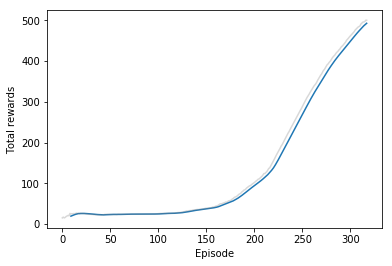

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

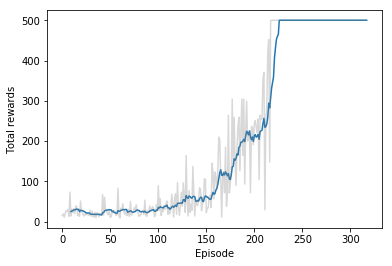

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

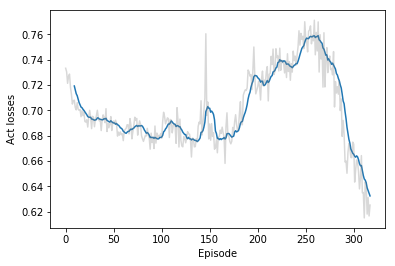

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

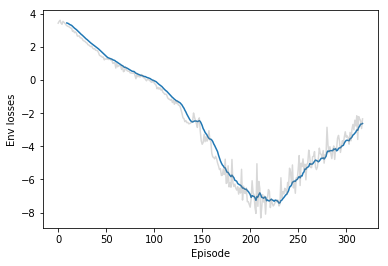

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

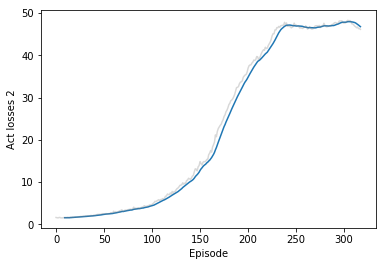

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
